# Examine Controls Across Data Sets

### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### File Locations

In [5]:
prefix = 'CN19S'

#Data Directory
directory = '../data/Dada2_seq_data/'

#Directory for saving Figures
plot_dir = '../figures/controls/'
print(plot_dir)

../figures/controls/


### Functions

In [3]:
# Dada2 Banzai Output Functions
levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

def make_metadata(infile):
    df = pd.read_csv(infile)
    df.set_index('sample_name', inplace=True)
    return df

#Raw Read Numbers
def make_taxa_otu_tables(infile):
    #infile = ASV_taxa_table_all.csv
    df = pd.read_csv(infile, sep=',')
    df.set_index('ASV', inplace=True)
    otu_table = df.drop(levels, axis=1)
    taxa_table = df[levels]
    return otu_table, taxa_table

#From fasta file create pandas df of ASV and sequence
def from_fasta_to_df(file):
    print(file)
    with open(file) as f:
        Ids=[]
        seqs =[]
        for strline in f:
            if strline[0]=='>':
                Ids.append(strline[1:].strip())
            else:
                seqs.append(strline.strip())
    print('Number of Ids:',len(Ids))
    print('Number of Seqs:',len(seqs))
    seq_dict = dict(zip(Ids, seqs))
    #make pandas df
    df= pd.DataFrame.from_dict(seq_dict,orient='index', columns=['sequence'])
    return df

#from metadata file, limit OTU table and taxa table to those present in those samples
def from_metadata_to_taxareads(meta_data, otu_table, taxa_table):
    #standard M6 output; sample_names as index; OTUs as index
    cols = list(meta_data)
    otu_lim = pd.concat([meta_data, otu_table.T],join='inner', axis=1)
    otu_lim.drop(cols, inplace=True, axis=1)
    otu_lim=otu_lim.T
    otu_lim['Total']=otu_lim.sum(axis=1)
    otu_lim = otu_lim.loc[otu_lim['Total']>0]
    otu_lim.drop('Total', axis=1, inplace=True)
    cols=list(otu_lim)
    taxa_lim=pd.concat([otu_lim, taxa_table], axis=1, join='inner')
    taxa_lim.drop(cols, inplace=True, axis=1)
    return otu_lim, taxa_lim

def from_taxa_to_otutab(taxa_table, otu_table):
    #remove OTUs not in the taxa table
    otu_lim = pd.concat([taxa_table, otu_table],join='inner', axis=1)
    otu_lim.drop(levels, inplace=True, axis=1)
    return otu_lim

#Plot number of reads in controls
#By Species
def OTUs_in_controls_plot(otu_tab, taxa_tab, meta_data):
    from palettable.tableau import Tableau_20 as pr
    cmap=pr.mpl_colormap
    #define control samples by non-environmental samples
    df=meta_data.copy()
    grouped = ['Kingdom', 'Phylum', 'Class', 'Order']
    #grouped= ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    df = df.loc[df['sample_type']!='environmental']
    df = df.loc[df['sample_type']!='positive']
    controls = df.index.tolist()
    print('controls:', controls)
    df=df.sort_index()
    df=df[['library','sample_type', 'target_gene']]
    #Now look at reads in controls
    df= pd.concat([df, otu_tab.T], axis=1,join='inner')
    df.index.name = 'sample_name'
    df=df.reset_index().set_index(['sample_name', 'library','sample_type','target_gene'])
    df=df.T
    df['Tot'] = df.sum(axis=1)
    df=df.loc[df['Tot']>0]
    col_name = list(df)[-1]
    print(col_name)
    df.drop(col_name, axis=1, inplace=True)
    df=pd.concat([df, taxa_tab], axis=1, join='inner')
    df=df.groupby(levels).sum()
    df['Tot'] = df.sum(axis=1)
    df=df.groupby(grouped).sum()
    df=df.sort_values('Tot', ascending=False)
    df=df.head(n=20)
    col_name = list(df)[-1]
    print(col_name)
    df.drop(col_name, axis=1, inplace=True)
    df=df.T
    df = df.sort_index()
    df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
    plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
    plt.title('Top 20 Control ASV Taxonomy by Raw Read Abundance', y=1.03, fontsize='14')
    plt.xlabel('Number of Raw Reads')
    filename=plot_dir +'Control_plot_'+marker+'.pdf'
    print(filename)
    plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
            orientation='landscape', papertype=None, format=None,
            transparent=True, bbox_inches='tight', pad_inches=1,
            frameon=None)
    plt.show()
    

# 12S

### Import Data

In [7]:
# Import Data

marker = '12S'

print('#####' +marker + '#####')

# otu table
file = prefix + '_'+marker+'_Dada2_otu_merged.csv'
print(directory+file)
df = pd.read_csv(directory + file)
df = df.rename(columns= {'Unnamed: 0':'ASV'})
df.set_index('ASV', inplace=True)
otu_all = df.copy()
print('Number ASVs:', len(df.index))
print('Number samples:', len(list(df)))


# taxa table
file = prefix + '_'+marker+'_Dada2_taxa_merged.csv'
print(directory+file)
df = pd.read_csv(directory+file)
df = df.rename(columns= {'Unnamed: 0':'ASV'})
df.set_index('ASV', inplace=True)
df['Kingdom'] = df['Kingdom'].str.replace('Eukaryota', 'Metazoa')
taxa_all = df.copy()
print('Number ASVs:', len(df.index))

# metadata
file = prefix + '_'+marker+'_Dada2_meta_merged.csv'
print(directory+file)
df = pd.read_csv(directory+file)
df.set_index('sample_name', inplace=True)
df['eventDate'] = pd.to_datetime(df['eventDate'])
meta_all = df.copy()
print('Number samples:', len(df.index))

#check what samples don't have date/time values
df = df.sort_values('eventDate')
#df.loc[df['eventDate'].isna(), 'eventDate'] = df['SAMPLING_date_time']
df=df.loc[df['eventDate'].isna()]
print('Samples without eventDate:')
print(df.index.unique())

# sequence table
file = prefix + '_'+marker+'_Dada2_seq_merged.csv'
print(directory+file)
df = pd.read_csv(directory +file)
df = df.rename(columns= {'Unnamed: 0':'ASV'})
df.set_index('ASV', inplace=True)
seq_all = df.copy()
print('Number ASVs:', len(df.index))
seq_all.head()


#####12S#####
../data/Dada2_seq_data/CN19S_12S_Dada2_otu_merged.csv
Number ASVs: 2827
Number samples: 286
../data/Dada2_seq_data/CN19S_12S_Dada2_taxa_merged.csv
Number ASVs: 2827
../data/Dada2_seq_data/CN19S_12S_Dada2_meta_merged.csv
Number samples: 286
Samples without eventDate:
Index(['CN19SESPKOA_SC60_eDNA_CE', 'CN19SESPKOA_SC59_eDNA_CE',
       'CN19SESPKOA_SC01_eDNA_CE', 'CN19SESPMV1_SC60_eDNA_CE',
       'CN19SESPMV1_SC59_eDNA_CE', 'V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT',
       'CN19F_CB_V4217_BT', 'V4196_CB_eDNA_BT', 'CN19S_CN19F_EB1_BT',
       'Art_Com1_BT', 'PCR_Blank1_BT', 'RTSF_NTC_1233_BT', 'pcrblank1_RR',
       'pcrblank2_RR', 'ArtComm1_RR', '20191203_EB_RR', 'pcrblank3_RR',
       'pcrblank_1_JJ', 'pcrblank_2_JJ', '20191022_EB_JJ', 'Artcomm2_JJ',
       'pcrblank_3_JJ', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE',
       'ArtComm1_CE', 'ArtComm2_CE', 'CN19SP3_OSU_EB1_CE',
       'CN19SP3_OSU_EB2_CE', 'RTSF_NTC_1284_CE'],
      dtype='object', name='sample_name')
../

/var/folders/5v/h4s_0pz17yb6f6krsxkzr5dw000b65/T/ipykernel_11086/3705730153.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['eventDate'] = pd.to_datetime(df['eventDate'])


sequence
ASV                                                     
ASV_1  CACCGCGGTTATACGAGAGACCCTAGTTGATTGAAGCGGCGTAAAG...
ASV_2  CACCGCGGTCAAACGAGCTAGTGCCCGAGCAGATAACTAACGGCGT...
ASV_3  CACCGCGGTTAAACGGGAGGCCCAAGTTGAAAGACAGCGGCGTAAA...
ASV_4  CACCGCGGTTATACGAGCGGCCCAAGTTGATAAAAATCGGCGTAAA...
ASV_5  CACCGCGGTCATACGAGTGTTAGCCCAAGCAGATGGTCAACGGCGT...

## Plot Controls

Sequenced negative PCR controls by plate ID:
- Plate JJ: 'pcrblank_1_JJ', 'pcrblank_2_JJ', 'pcrblank_3_JJ'
- Plate RR: 'pcrblank1_RR', 'pcrblank2_RR', 'pcrblank3_RR'
- Plate CE: 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE'
- Plate BT: 'PCR_Blank1_BT'

MSU RTSF sequenced controls:
- Plate BT: 'RTSF_NTC_1233_BT'
- Plate CE: 'RTSF_NTC_1284_CE'

Sequenced extraction blanks by plate ID:
- Plate BT: 'CN19S_CN19F_EB1_BT'
- Plate RR: '20191203_EB_RR'
- Plate JJ: '20191022_EB_JJ'
- Plate CE: 'CN19SP3_OSU_EB1_CE', 'CN19SP3_OSU_EB2_CE'

Sequenced negative sampling controls by plate ID:
- Plate BT: 'V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT','CN19F_CB_V4217_BT', 'V4196_CB_eDNA_BT'
- Plate CE: 'CN19SESPKOA_SC60_eDNA_CE','CN19SESPKOA_SC59_eDNA_CE','CN19SESPKOA_SC01_eDNA_CE','CN19SESPMV1_SC60_eDNA_CE','CN19SESPMV1_SC59_eDNA_CE'


In [43]:
from palettable.tableau import Tableau_20 as pr
cmap=pr.mpl_colormap
colors = pr.mpl_colors

### Plate JJ controls

controls: ['pcrblank_1_JJ', 'pcrblank_2_JJ', '20191022_EB_JJ', 'pcrblank_3_JJ']
('Tot', '', '')
Tot
../figures/controls/PlateJJ_controls_12S.png


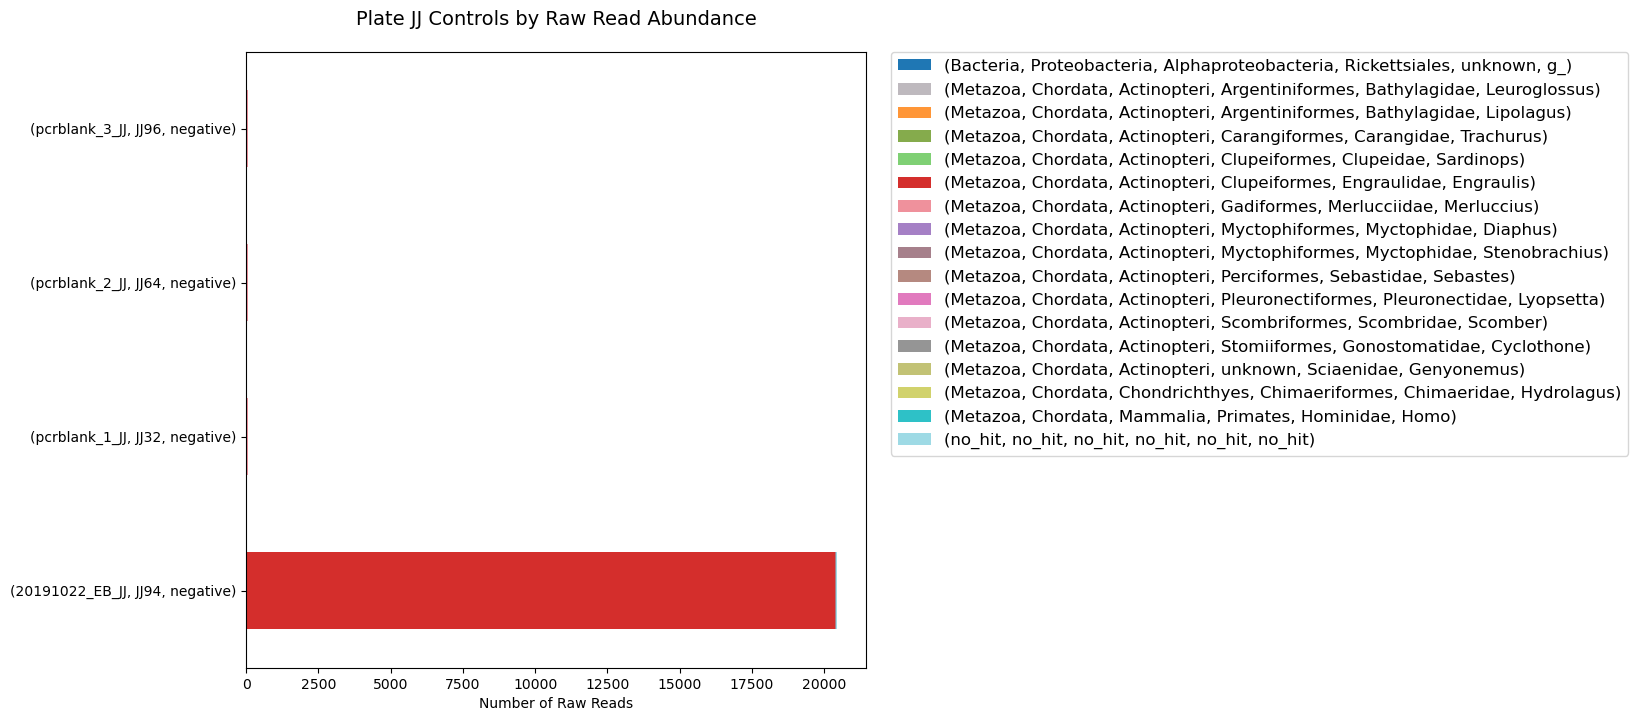

Kingdom                                     Bacteria         Metazoa  \
Phylum                                Proteobacteria        Chordata   
Class                            Alphaproteobacteria     Actinopteri   
Order                                  Rickettsiales Argentiniformes   
Family                                       unknown    Bathylagidae   
Genus                                             g_    Leuroglossus   
(20191022_EB_JJ, JJ94, negative)                   1               6   
(pcrblank_1_JJ, JJ32, negative)                    0               6   
(pcrblank_2_JJ, JJ64, negative)                    0               3   
(pcrblank_3_JJ, JJ96, negative)                    0               7   

Kingdom                                                                \
Phylum                                                                  
Class                                                                   
Order                                      Carangiformes Clupeiformes   
Family                                        Carangidae    Clupeidae   
Genus                            Lipolagus     Trachurus    Sardinops   
(20191022_EB_JJ, JJ94, negative)         5             0            0   
(pcrblank_1_JJ, JJ32, negative)          0             3            2   
(pcrblank_2_JJ, JJ64, negative)          1             1            2   
(pcrblank_3_JJ, JJ96, negative)          0             0            6   

Kingdom                                                                   \
Phylum                                                                     
Class                                                                      
Order                                          Gadiformes Myctophiformes   
Family                           Engraulidae Merlucciidae    Myctophidae   
Genus                              Engraulis   Merluccius        Diaphus   
(20191022_EB_JJ, JJ94, negative)       20368            6              0   
(pcrblank_1_JJ, JJ32, negative)           35            3              2   
(pcrblank_2_JJ, JJ64, negative)           38            4              0   
(pcrblank_3_JJ, JJ96, negative)           33            8              4   

Kingdom                                                                       \
Phylum                                                                         
Class                                                                          
Order                                          Perciformes Pleuronectiformes   
Family                                          Sebastidae    Pleuronectidae   
Genus                            Stenobrachius    Sebastes         Lyopsetta   
(20191022_EB_JJ, JJ94, negative)            10           9                 4   
(pcrblank_1_JJ, JJ32, negative)              8           2                 0   
(pcrblank_2_JJ, JJ64, negative)              5           2                 0   
(pcrblank_3_JJ, JJ96, negative)              7           2                 0   

Kingdom                                                                   \
Phylum                                                                     
Class                                                                      
Order                            Scombriformes   Stomiiformes    unknown   
Family                              Scombridae Gonostomatidae Sciaenidae   
Genus                                  Scomber     Cyclothone Genyonemus   
(20191022_EB_JJ, JJ94, negative)             0              0          5   
(pcrblank_1_JJ, JJ32, negative)              1              2          0   
(pcrblank_2_JJ, JJ64, negative)              0              6          0   
(pcrblank_3_JJ, JJ96, negative)              0              1          0   

Kingdom                                                   no_hit  
Phylum                                                    no_hit  
Class                            Chondrichthyes  Mammalia no_hit  
Order                   

In [44]:

grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
controls = [ 'pcrblank_1_JJ', 'pcrblank_2_JJ', '20191022_EB_JJ',
       'pcrblank_3_JJ']

print('controls:', controls)

df=meta_all[['library','sample_type']].copy()
df = df.loc[df.index.isin(controls)]

df=df.sort_index()
#Now look at reads in controls
df= pd.concat([df, otu_all.T], axis=1,join='inner')
df.index.name = 'sample_name'
df=df.reset_index().set_index(['sample_name', 'library','sample_type'])
df=df.T
df['Tot'] = df.sum(axis=1)
df=df.loc[df['Tot']>0]
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df=pd.concat([df, taxa_all], axis=1, join='inner')
df=df.groupby(levels).sum()
df['Tot'] = df.sum(axis=1)
df=df.groupby(grouped).sum()
df=df.sort_values('Tot', ascending=False)
df=df.head(n=20)
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df = df.sort_index()
df=df.T
df = df.sort_index()
df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.title('Plate JJ Controls by Raw Read Abundance', y=1.03, fontsize='14')
plt.xlabel('Number of Raw Reads')
filename=plot_dir +'PlateJJ_controls_'+marker+'.png'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',  format=None,
        transparent=True, bbox_inches='tight', pad_inches=1)
plt.show()
            
df

### Plate RR controls

controls: ['pcrblank1_RR', 'pcrblank2_RR', '20191203_EB_RR', 'pcrblank3_RR']
('Tot', '', '')
Tot
../figures/controls/PlateRR_controls_12S.png


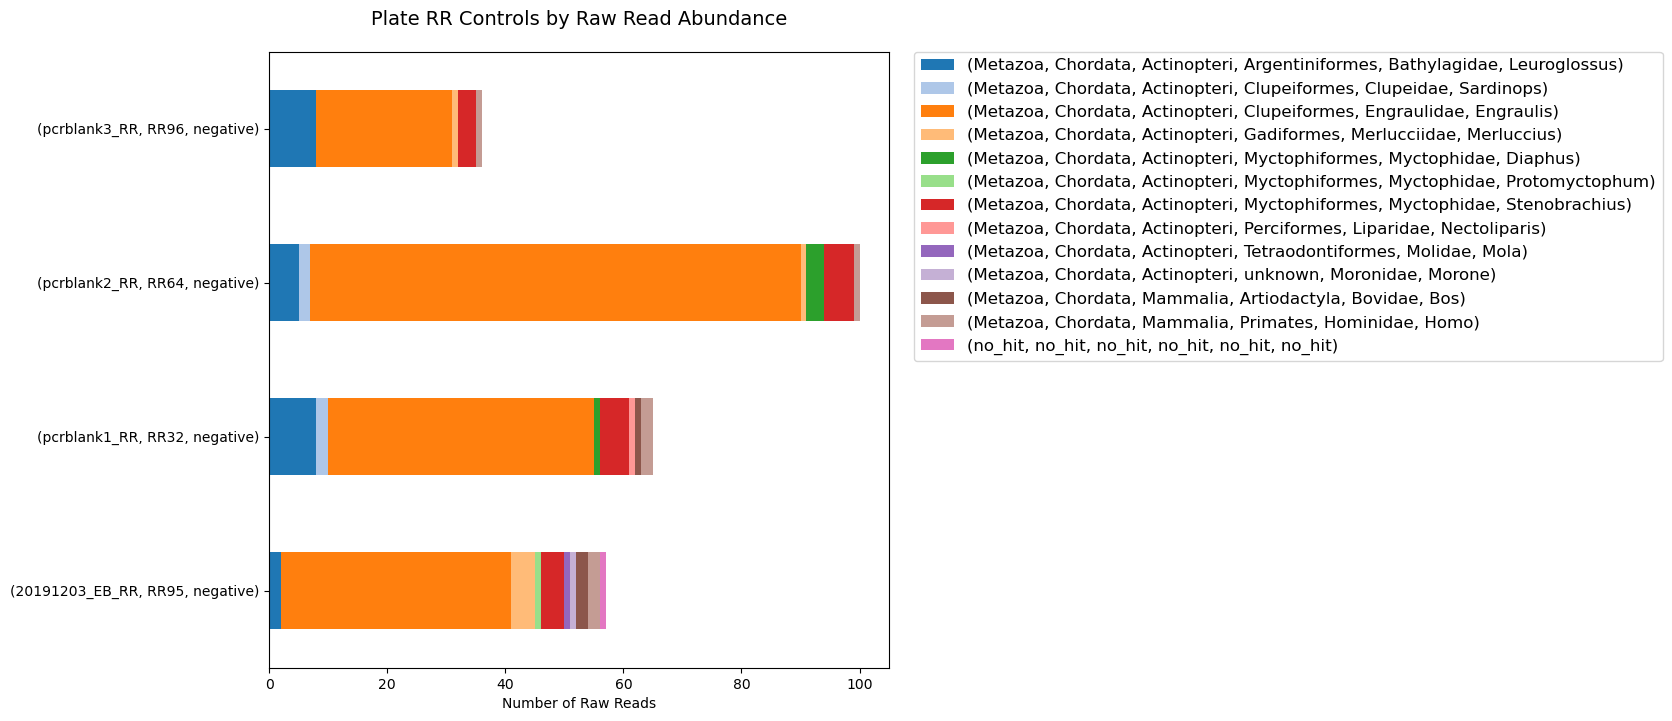

Kingdom                                  Metazoa                           \
Phylum                                  Chordata                            
Class                                Actinopteri                            
Order                            Argentiniformes Clupeiformes               
Family                              Bathylagidae    Clupeidae Engraulidae   
Genus                               Leuroglossus    Sardinops   Engraulis   
(20191203_EB_RR, RR95, negative)               2            0          39   
(pcrblank1_RR, RR32, negative)                 8            2          45   
(pcrblank2_RR, RR64, negative)                 5            2          83   
(pcrblank3_RR, RR96, negative)                 8            0          23   

Kingdom                                                                      \
Phylum                                                                        
Class                                                                         
Order                              Gadiformes Myctophiformes                  
Family                           Merlucciidae    Myctophidae                  
Genus                              Merluccius        Diaphus Protomyctophum   
(20191203_EB_RR, RR95, negative)            4              0              1   
(pcrblank1_RR, RR32, negative)              0              1              0   
(pcrblank2_RR, RR64, negative)              1              3              0   
(pcrblank3_RR, RR96, negative)              1              0              0   

Kingdom                                                                        \
Phylum                                                                          
Class                                                                           
Order                                           Perciformes Tetraodontiformes   
Family                                            Liparidae           Molidae   
Genus                            Stenobrachius Nectoliparis              Mola   
(20191203_EB_RR, RR95, negative)             4            0                 1   
(pcrblank1_RR, RR32, negative)               5            1                 0   
(pcrblank2_RR, RR64, negative)               5            0                 0   
(pcrblank3_RR, RR96, negative)               3            0                 0   

Kingdom                                                           no_hit  
Phylum                                                            no_hit  
Class                                          Mammalia           no_hit  
Order                              unknown Artiodactyla  Primates no_hit  
Family                           Moronidae      Bovidae Hominidae no_hit  
Genus                               Morone          Bos      Homo no_hit  
(20191203_EB_RR, RR95, negative)         1            2         2      1  
(pcrblank1_RR, RR32, negative)           0            1         2      0  
(pcrblank2_RR, RR64, negative)           0            0         1      0  
(pcrblank3_RR, RR96, negative)           0            0         1      0

In [45]:

grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
controls = [ 'pcrblank1_RR',
       'pcrblank2_RR',  '20191203_EB_RR', 'pcrblank3_RR']

print('controls:', controls)

df=meta_all[['library','sample_type']].copy()
df = df.loc[df.index.isin(controls)]

df=df.sort_index()
#Now look at reads in controls
df= pd.concat([df, otu_all.T], axis=1,join='inner')
df.index.name = 'sample_name'
df=df.reset_index().set_index(['sample_name', 'library','sample_type'])
df=df.T
df['Tot'] = df.sum(axis=1)
df=df.loc[df['Tot']>0]
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df=pd.concat([df, taxa_all], axis=1, join='inner')
df=df.groupby(levels).sum()
df['Tot'] = df.sum(axis=1)
df=df.groupby(grouped).sum()
df=df.sort_values('Tot', ascending=False)
df=df.head(n=20)
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df = df.sort_index()
df=df.T
df = df.sort_index()
df.plot(kind='barh',stacked=True, color=colors, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.title('Plate RR Controls by Raw Read Abundance', y=1.03, fontsize='14')
plt.xlabel('Number of Raw Reads')
filename=plot_dir +'PlateRR_controls_'+marker+'.png'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',  format=None,
        transparent=True, bbox_inches='tight', pad_inches=1)
plt.show()
            
df

### Plate BT controls

controls: ['V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT', 'CN19F_CB_V4217_BT', 'V4196_CB_eDNA_BT', 'CN19S_CN19F_EB1_BT', 'PCR_Blank1_BT', 'RTSF_NTC_1233_BT']
('Tot', '', '')
Tot
../figures/controls/PlateBT_controls_12S.png


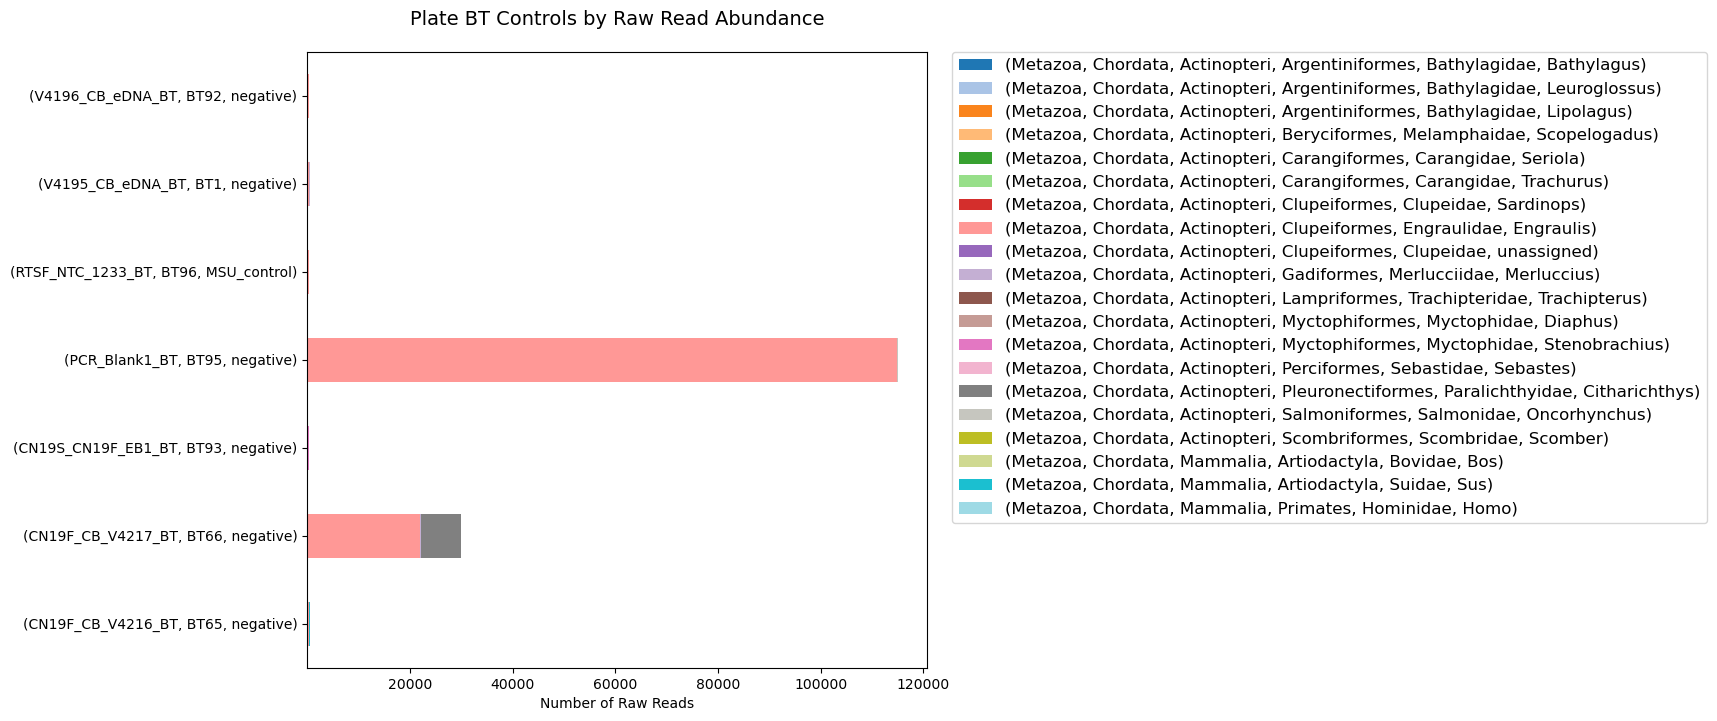

Kingdom                                       Metazoa                         \
Phylum                                       Chordata                          
Class                                     Actinopteri                          
Order                                 Argentiniformes                          
Family                                   Bathylagidae                          
Genus                                      Bathylagus Leuroglossus Lipolagus   
(CN19F_CB_V4216_BT, BT65, negative)                10            5         9   
(CN19F_CB_V4217_BT, BT66, negative)                 0            2         0   
(CN19S_CN19F_EB1_BT, BT93, negative)                1           18         4   
(PCR_Blank1_BT, BT95, negative)                     1           59         0   
(RTSF_NTC_1233_BT, BT96, MSU_control)               0            3         3   
(V4195_CB_eDNA_BT, BT1, negative)                   7           11        17   
(V4196_CB_eDNA_BT, BT92, negative)                  0            3        25   

Kingdom                                                                     \
Phylum                                                                       
Class                                                                        
Order                                 Beryciformes Carangiformes             
Family                                Melamphaidae    Carangidae             
Genus                                 Scopelogadus       Seriola Trachurus   
(CN19F_CB_V4216_BT, BT65, negative)              0             0         0   
(CN19F_CB_V4217_BT, BT66, negative)              6             0         0   
(CN19S_CN19F_EB1_BT, BT93, negative)             0             2         3   
(PCR_Blank1_BT, BT95, negative)                  0             4         0   
(RTSF_NTC_1233_BT, BT96, MSU_control)            0             0        14   
(V4195_CB_eDNA_BT, BT1, negative)                0             0         0   
(V4196_CB_eDNA_BT, BT92, negative)               0            16         0   

Kingdom                                                                    \
Phylum                                                                      
Class                                                                       
Order                                 Clupeiformes                          
Family                                   Clupeidae Engraulidae  Clupeidae   
Genus                                    Sardinops   Engraulis unassigned   
(CN19F_CB_V4216_BT, BT65, negative)              0         321          0   
(CN19F_CB_V4217_BT, BT66, negative)              2       22068          0   
(CN19S_CN19F_EB1_BT, BT93, negative)             8         160          1   
(PCR_Blank1_BT, BT95, negative)                  0      114848          3   
(RTSF_NTC_1233_BT, BT96, MSU_control)            6         333          0   
(V4195_CB_eDNA_BT, BT1, negative)                0         380          0   
(V4196_CB_eDNA_BT, BT92, negative)               0         264          5   

Kingdom                                                            \
Phylum                                                              
Class                                                               
Order                                   Gadiformes   Lampriformes   
Family                                Merlucciidae Trachipteridae   
Genus                                   Merluccius   Trachipterus   
(CN19F_CB_V4216_BT, BT65, negative)             29              5   
(CN19F_CB_V4217_BT, BT66, negative)             15              0   
(CN19S_CN19F_EB1_BT, BT93, negative)            66              0   
(PCR_Blank1_BT, BT95, negative)                  6              0   
(RTSF_NTC_1233_BT, BT96, MSU_control)           10              0   
(V4195_CB_eDNA_BT, BT1, negative)               64              8   
(V4196_CB_eDNA_BT, BT92, negative)               0              0   

Kingdom                                     

In [46]:

grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
controls = [  'V4195_CB_eDNA_BT', 'CN19F_CB_V4216_BT',
       'CN19F_CB_V4217_BT', 'V4196_CB_eDNA_BT', 'CN19S_CN19F_EB1_BT',
       'PCR_Blank1_BT', 'RTSF_NTC_1233_BT']

print('controls:', controls)

df=meta_all[['library','sample_type']].copy()
df = df.loc[df.index.isin(controls)]

df=df.sort_index()
#Now look at reads in controls
df= pd.concat([df, otu_all.T], axis=1,join='inner')
df.index.name = 'sample_name'
df=df.reset_index().set_index(['sample_name', 'library','sample_type'])
df=df.T
df['Tot'] = df.sum(axis=1)
df=df.loc[df['Tot']>0]
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df=pd.concat([df, taxa_all], axis=1, join='inner')
df=df.groupby(levels).sum()
df['Tot'] = df.sum(axis=1)
df=df.groupby(grouped).sum()
df=df.sort_values('Tot', ascending=False)
df=df.head(n=20)
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df = df.sort_index()
df=df.T
df = df.sort_index()
df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.title('Plate BT Controls by Raw Read Abundance', y=1.03, fontsize='14')
plt.xlabel('Number of Raw Reads')
filename=plot_dir +'PlateBT_controls_'+marker+'.png'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',  format=None,
        transparent=True, bbox_inches='tight', pad_inches=1)
plt.show()
            
df

### Plate CE controls

controls: ['CN19SESPKOA_SC59_eDNA_CE', 'CN19SESPKOA_SC01_eDNA_CE', 'CN19SESPMV1_SC59_eDNA_CE', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE', 'CN19SP3_OSU_EB1_CE', 'CN19SP3_OSU_EB2_CE', 'RTSF_NTC_1284_CE']
('Tot', '', '')
Tot
../figures/controls/PlateCE_controls_12S.png


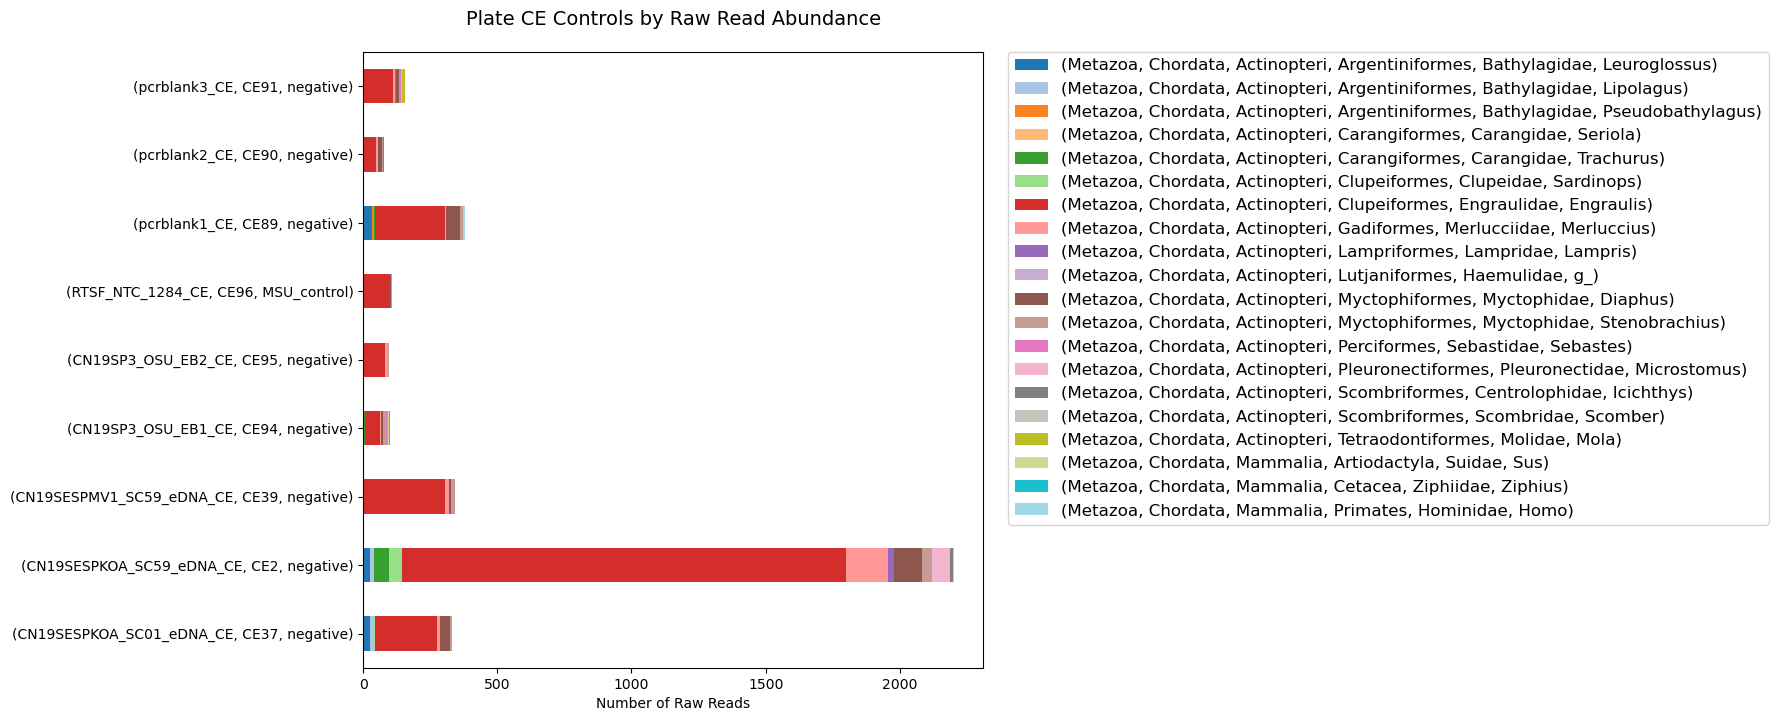

Kingdom                                            Metazoa            \
Phylum                                            Chordata             
Class                                          Actinopteri             
Order                                      Argentiniformes             
Family                                        Bathylagidae             
Genus                                         Leuroglossus Lipolagus   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)              27        11   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)               27        13   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)               0         2   
(CN19SP3_OSU_EB1_CE, CE94, negative)                     0         4   
(CN19SP3_OSU_EB2_CE, CE95, negative)                     0         0   
(RTSF_NTC_1284_CE, CE96, MSU_control)                    1         0   
(pcrblank1_CE, CE89, negative)                          32         0   
(pcrblank2_CE, CE90, negative)                           3         0   
(pcrblank3_CE, CE91, negative)                           2         0   

Kingdom                                                                    \
Phylum                                                                      
Class                                                                       
Order                                                       Carangiformes   
Family                                                         Carangidae   
Genus                                      Pseudobathylagus       Seriola   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)                0             0   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)                 0             0   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)                0             0   
(CN19SP3_OSU_EB1_CE, CE94, negative)                      0             1   
(CN19SP3_OSU_EB2_CE, CE95, negative)                      0             1   
(RTSF_NTC_1284_CE, CE96, MSU_control)                     0             1   
(pcrblank1_CE, CE89, negative)                            9             0   
(pcrblank2_CE, CE90, negative)                            0             0   
(pcrblank3_CE, CE91, negative)                            0             2   

Kingdom                                                                        \
Phylum                                                                          
Class                                                                           
Order                                                Clupeiformes               
Family                                                  Clupeidae Engraulidae   
Genus                                      Trachurus    Sardinops   Engraulis   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)         0            8         230   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)         57           48        1656   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)         0            0         305   
(CN19SP3_OSU_EB1_CE, CE94, negative)               1            2          54   
(CN19SP3_OSU_EB2_CE, CE95, negative)               0            0          82   
(RTSF_NTC_1284_CE, CE96, MSU_control)              0            0          95   
(pcrblank1_CE, CE89, negative)                     2            0         261   
(pcrblank2_CE, CE90, negative)                     0            0          44   
(pcrblank3_CE, CE91, negative)                     0            1         106   

Kingdom                                                               \
Phylum                                                                 
Class                                                                  
Order                                        Gadiformes Lampriformes   
Family                                     Merlucciidae    Lampridae   
Genus                                        Merluccius      Lampris   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)           12            0   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)  

In [47]:

grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
controls = [  'CN19SESPKOA_SC59_eDNA_CE',
       'CN19SESPKOA_SC01_eDNA_CE',
       'CN19SESPMV1_SC59_eDNA_CE', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE',
        'CN19SP3_OSU_EB1_CE','CN19SP3_OSU_EB2_CE', 'RTSF_NTC_1284_CE']

print('controls:', controls)

df=meta_all[['library','sample_type']].copy()
df = df.loc[df.index.isin(controls)]

df=df.sort_index()
#Now look at reads in controls
df= pd.concat([df, otu_all.T], axis=1,join='inner')
df.index.name = 'sample_name'
df=df.reset_index().set_index(['sample_name', 'library','sample_type'])
df=df.T
df['Tot'] = df.sum(axis=1)
df=df.loc[df['Tot']>0]
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df=pd.concat([df, taxa_all], axis=1, join='inner')
df=df.groupby(levels).sum()
df['Tot'] = df.sum(axis=1)
df=df.groupby(grouped).sum()
df=df.sort_values('Tot', ascending=False)
df=df.head(n=20)
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df = df.sort_index()
df=df.T
df = df.sort_index()
df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.title('Plate CE Controls by Raw Read Abundance', y=1.03, fontsize='14')
plt.xlabel('Number of Raw Reads')
filename=plot_dir +'PlateCE_controls_'+marker+'.png'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',  format=None,
        transparent=True, bbox_inches='tight', pad_inches=1)
plt.show()
            
df

### Negative PCR Controls

controls: ['PCR_Blank1_BT', 'RTSF_NTC_1233_BT', 'pcrblank1_RR', 'pcrblank2_RR', 'pcrblank3_RR', 'pcrblank_1_JJ', 'pcrblank_2_JJ', 'pcrblank_3_JJ', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE', 'RTSF_NTC_1284_CE']
('Tot', '', '')
Tot
../figures/controls/NegPCR_controls_12S.png


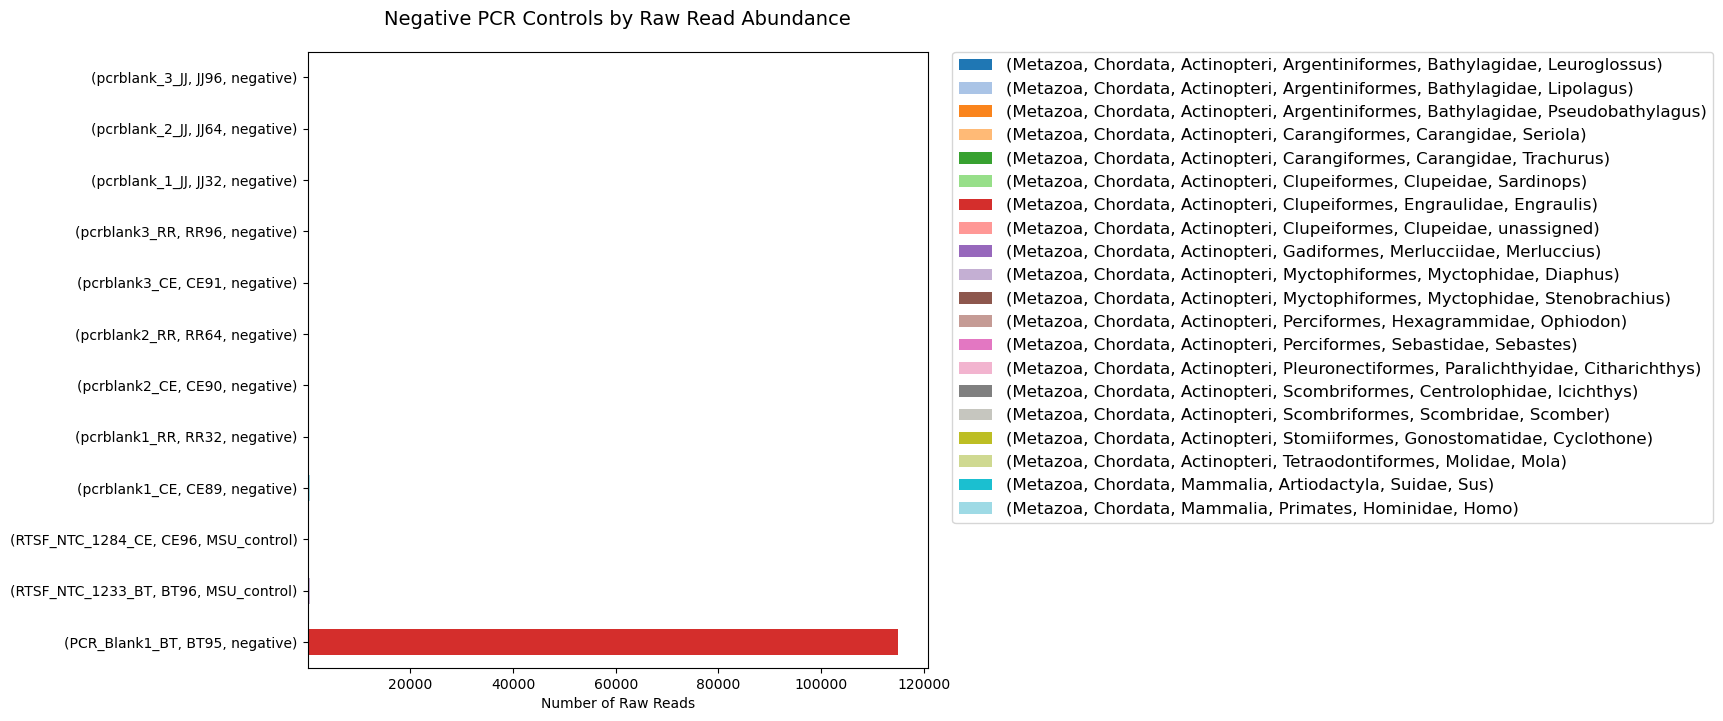

Kingdom                                       Metazoa            \
Phylum                                       Chordata             
Class                                     Actinopteri             
Order                                 Argentiniformes             
Family                                   Bathylagidae             
Genus                                    Leuroglossus Lipolagus   
(PCR_Blank1_BT, BT95, negative)                    59         0   
(RTSF_NTC_1233_BT, BT96, MSU_control)               3         3   
(RTSF_NTC_1284_CE, CE96, MSU_control)               1         0   
(pcrblank1_CE, CE89, negative)                     32         0   
(pcrblank1_RR, RR32, negative)                      8         0   
(pcrblank2_CE, CE90, negative)                      3         0   
(pcrblank2_RR, RR64, negative)                      5         0   
(pcrblank3_CE, CE91, negative)                      2         0   
(pcrblank3_RR, RR96, negative)                      8         0   
(pcrblank_1_JJ, JJ32, negative)                     6         0   
(pcrblank_2_JJ, JJ64, negative)                     3         1   
(pcrblank_3_JJ, JJ96, negative)                     7         0   

Kingdom                                                               \
Phylum                                                                 
Class                                                                  
Order                                                  Carangiformes   
Family                                                    Carangidae   
Genus                                 Pseudobathylagus       Seriola   
(PCR_Blank1_BT, BT95, negative)                      1             4   
(RTSF_NTC_1233_BT, BT96, MSU_control)                0             0   
(RTSF_NTC_1284_CE, CE96, MSU_control)                0             1   
(pcrblank1_CE, CE89, negative)                       9             0   
(pcrblank1_RR, RR32, negative)                       0             0   
(pcrblank2_CE, CE90, negative)                       0             0   
(pcrblank2_RR, RR64, negative)                       0             0   
(pcrblank3_CE, CE91, negative)                       0             2   
(pcrblank3_RR, RR96, negative)                       0             0   
(pcrblank_1_JJ, JJ32, negative)                      0             0   
(pcrblank_2_JJ, JJ64, negative)                      0             0   
(pcrblank_3_JJ, JJ96, negative)                      0             0   

Kingdom                                                                   \
Phylum                                                                     
Class                                                                      
Order                                           Clupeiformes               
Family                                             Clupeidae Engraulidae   
Genus                                 Trachurus    Sardinops   Engraulis   
(PCR_Blank1_BT, BT95, negative)               0            0      114848   
(RTSF_NTC_1233_BT, BT96, MSU_control)        14            6         333   
(RTSF_NTC_1284_CE, CE96, MSU_control)         0            0          95   
(pcrblank1_CE, CE89, negative)                2            0         261   
(pcrblank1_RR, RR32, negative)                0            2          45   
(pcrblank2_CE, CE90, negative)                0            0          44   
(pcrblank2_RR, RR64, negative)                0            2          83   
(pcrblank3_CE, CE91, negative)                0            1         106   
(pcrblank3_RR, RR96, negative)                0            0          23   
(pcrblank_1_JJ, JJ32, negative)               3            2          35   
(pcrblank_2_JJ, JJ64, negative)               1            2          38   
(pcrblank_3_JJ, JJ96, negative)               0            6          33   

Kingdom                                                                       \
Phylum                                         

In [49]:

grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
controls = [ 'PCR_Blank1_BT', 'RTSF_NTC_1233_BT', 'pcrblank1_RR',
       'pcrblank2_RR',  'pcrblank3_RR',
       'pcrblank_1_JJ', 'pcrblank_2_JJ',
       'pcrblank_3_JJ', 'pcrblank1_CE', 'pcrblank2_CE', 'pcrblank3_CE',
        'RTSF_NTC_1284_CE']

print('controls:', controls)

df=meta_all[['library','sample_type']].copy()
df = df.loc[df.index.isin(controls)]

df=df.sort_index()
#Now look at reads in controls
df= pd.concat([df, otu_all.T], axis=1,join='inner')
df.index.name = 'sample_name'
df=df.reset_index().set_index(['sample_name', 'library','sample_type'])
df=df.T
df['Tot'] = df.sum(axis=1)
df=df.loc[df['Tot']>0]
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df=pd.concat([df, taxa_all], axis=1, join='inner')
df=df.groupby(levels).sum()
df['Tot'] = df.sum(axis=1)
df=df.groupby(grouped).sum()
df=df.sort_values('Tot', ascending=False)
df=df.head(n=20)
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df = df.sort_index()
df=df.T
df = df.sort_index()
df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.title('Negative PCR Controls by Raw Read Abundance', y=1.03, fontsize='14')
plt.xlabel('Number of Raw Reads')
filename=plot_dir +'NegPCR_controls_'+marker+'.png'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',  format=None,
        transparent=True, bbox_inches='tight', pad_inches=1)
plt.show()
            
df

### ESP Controls

controls: ['CN19SESPKOA_SC60_eDNA_CE', 'CN19SESPKOA_SC59_eDNA_CE', 'CN19SESPKOA_SC01_eDNA_CE', 'CN19SESPMV1_SC60_eDNA_CE', 'CN19SESPMV1_SC59_eDNA_CE']
('Tot', '', '')
Tot
../figures/controls/ESP_controls_12S.png


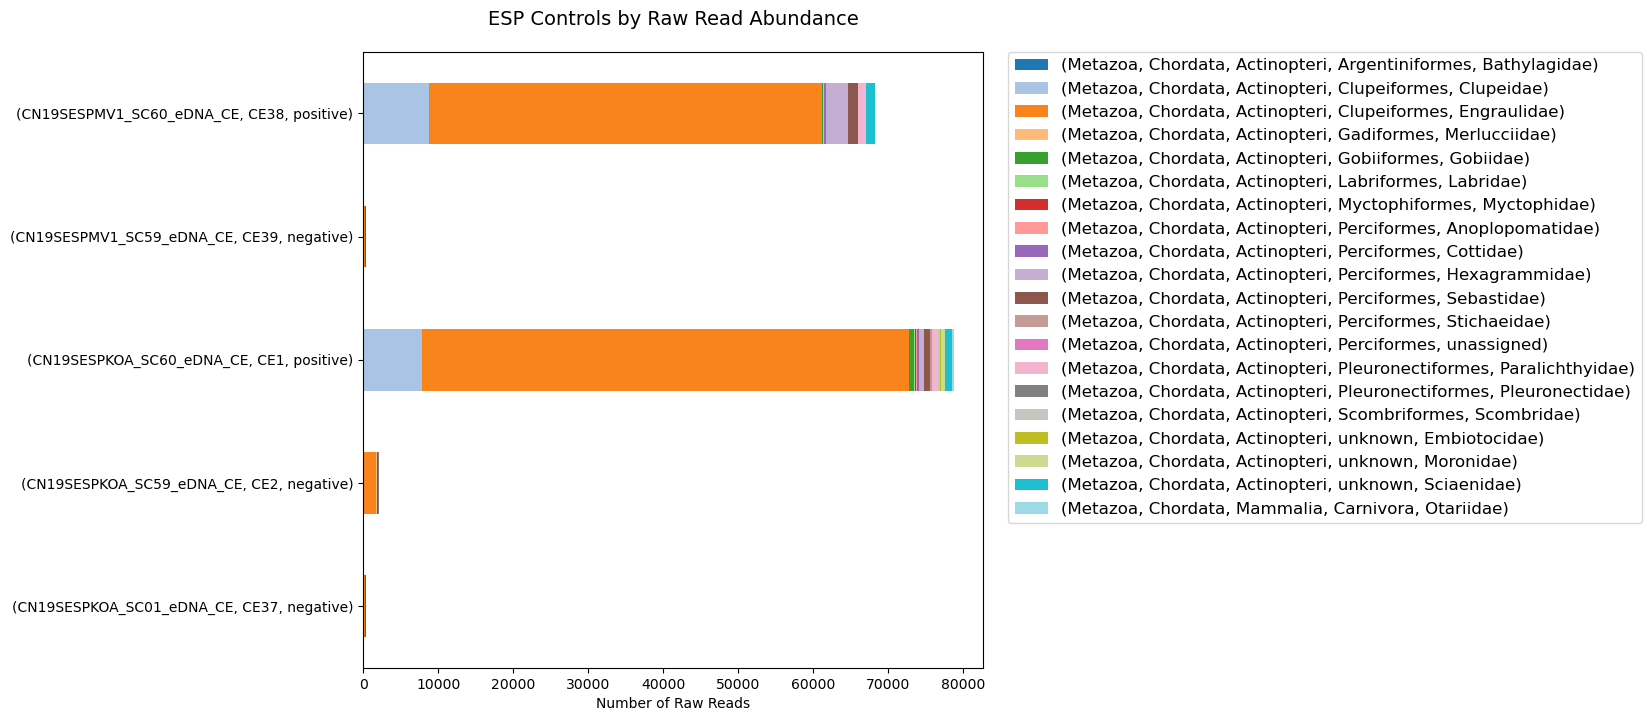

Kingdom                                            Metazoa               \
Phylum                                            Chordata                
Class                                          Actinopteri                
Order                                      Argentiniformes Clupeiformes   
Family                                        Bathylagidae    Clupeidae   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)              38            8   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)               40           48   
(CN19SESPKOA_SC60_eDNA_CE, CE1, positive)               17         7865   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)               2            0   
(CN19SESPMV1_SC60_eDNA_CE, CE38, positive)               9         8762   

Kingdom                                                              \
Phylum                                                                
Class                                                                 
Order                                                    Gadiformes   
Family                                     Engraulidae Merlucciidae   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)         230           12   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)         1656          156   
(CN19SESPKOA_SC60_eDNA_CE, CE1, positive)        64888            2   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)         305           13   
(CN19SESPMV1_SC60_eDNA_CE, CE38, positive)       52316           16   

Kingdom                                                             \
Phylum                                                               
Class                                                                
Order                                      Gobiiformes Labriformes   
Family                                        Gobiidae    Labridae   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)           0           0   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)            0           0   
(CN19SESPKOA_SC60_eDNA_CE, CE1, positive)          627         183   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)           0           0   
(CN19SESPMV1_SC60_eDNA_CE, CE38, positive)         165          87   

Kingdom                                                                    \
Phylum                                                                      
Class                                                                       
Order                                      Myctophiformes     Perciformes   
Family                                        Myctophidae Anoplopomatidae   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)             43               0   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)             140               0   
(CN19SESPKOA_SC60_eDNA_CE, CE1, positive)              26             187   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)             21               0   
(CN19SESPMV1_SC60_eDNA_CE, CE38, positive)             63               0   

Kingdom                                                                       \
Phylum                                                                         
Class                                                                          
Order                                                                          
Family                                     Cottidae Hexagrammidae Sebastidae   
(CN19SESPKOA_SC01_eDNA_CE, CE37, negative)        0             0          0   
(CN19SESPKOA_SC59_eDNA_CE, CE2, negative)         0             0          0   
(CN19SESPKOA_SC60_eDNA_CE, CE1, positive)       286           683        715   
(CN19SESPMV1_SC59_eDNA_CE, CE39, negative)        0             0          0   
(CN19SESPMV1_SC60_eDNA_CE, CE38, positive)      244          2933       1307   

Kingdom                                                            \
Phylum                                                              
Class                                                               
Order                                                     

In [50]:

grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family']
controls = ['CN19SESPKOA_SC60_eDNA_CE', 'CN19SESPKOA_SC59_eDNA_CE',
       'CN19SESPKOA_SC01_eDNA_CE', 'CN19SESPMV1_SC60_eDNA_CE',
       'CN19SESPMV1_SC59_eDNA_CE']

print('controls:', controls)

df=meta_all[['library','sample_type']].copy()
df = df.loc[df.index.isin(controls)]

df=df.sort_index()
#Now look at reads in controls
df= pd.concat([df, otu_all.T], axis=1,join='inner')
df.index.name = 'sample_name'
df=df.reset_index().set_index(['sample_name', 'library','sample_type'])
df=df.T
df['Tot'] = df.sum(axis=1)
df=df.loc[df['Tot']>0]
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df=pd.concat([df, taxa_all], axis=1, join='inner')
df=df.groupby(levels).sum()
df['Tot'] = df.sum(axis=1)
df=df.groupby(grouped).sum()
df=df.sort_values('Tot', ascending=False)
df=df.head(n=20)
col_name = list(df)[-1]
print(col_name)
df.drop(col_name, axis=1, inplace=True)
df = df.sort_index()
df=df.T
df = df.sort_index()
df.plot(kind='barh',stacked=True, cmap=cmap, figsize=[8,8])
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
plt.title('ESP Controls by Raw Read Abundance', y=1.03, fontsize='14')
plt.xlabel('Number of Raw Reads')
filename=plot_dir +'ESP_controls_'+marker+'.png'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape',  format=None,
        transparent=True, bbox_inches='tight', pad_inches=1)
plt.show()
            
df

#### Plot ASVs in Controls across environmental samples

CE
('Tot_neg', '', '')
['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', ('Tot_neg', '', '')]
../figures/controls/ASVs_NegControl_plot_12S_plateCE.pdf


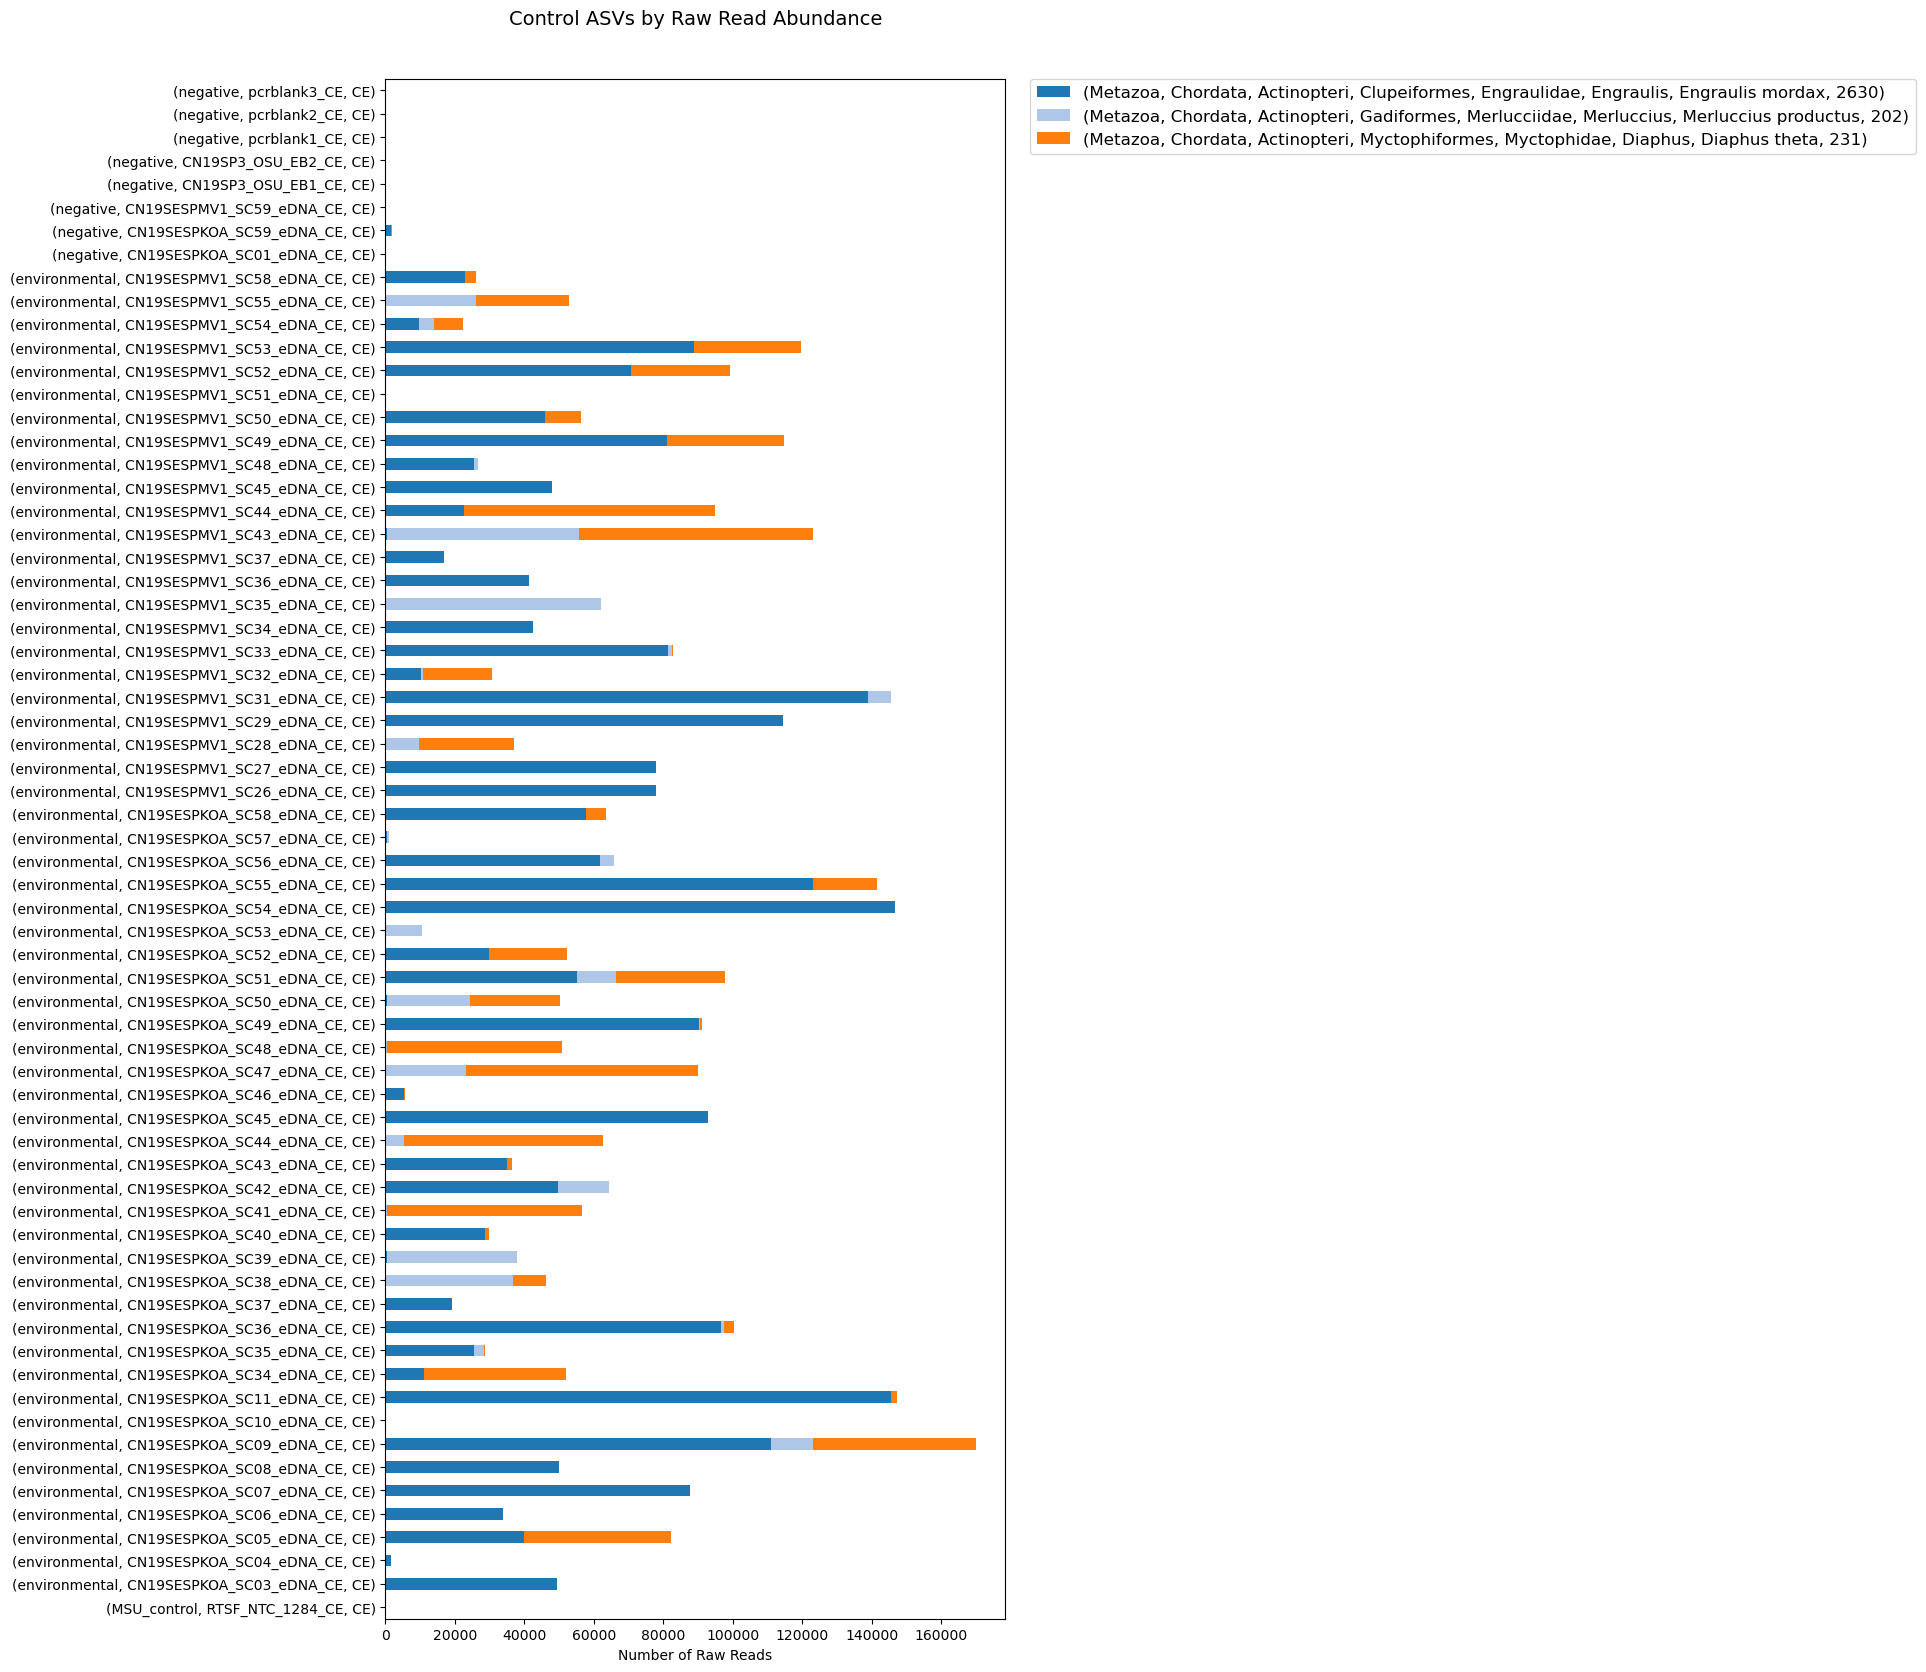

JJ
('Tot_neg', '', '')
['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', ('Tot_neg', '', '')]
../figures/controls/ASVs_NegControl_plot_12S_plateJJ.pdf


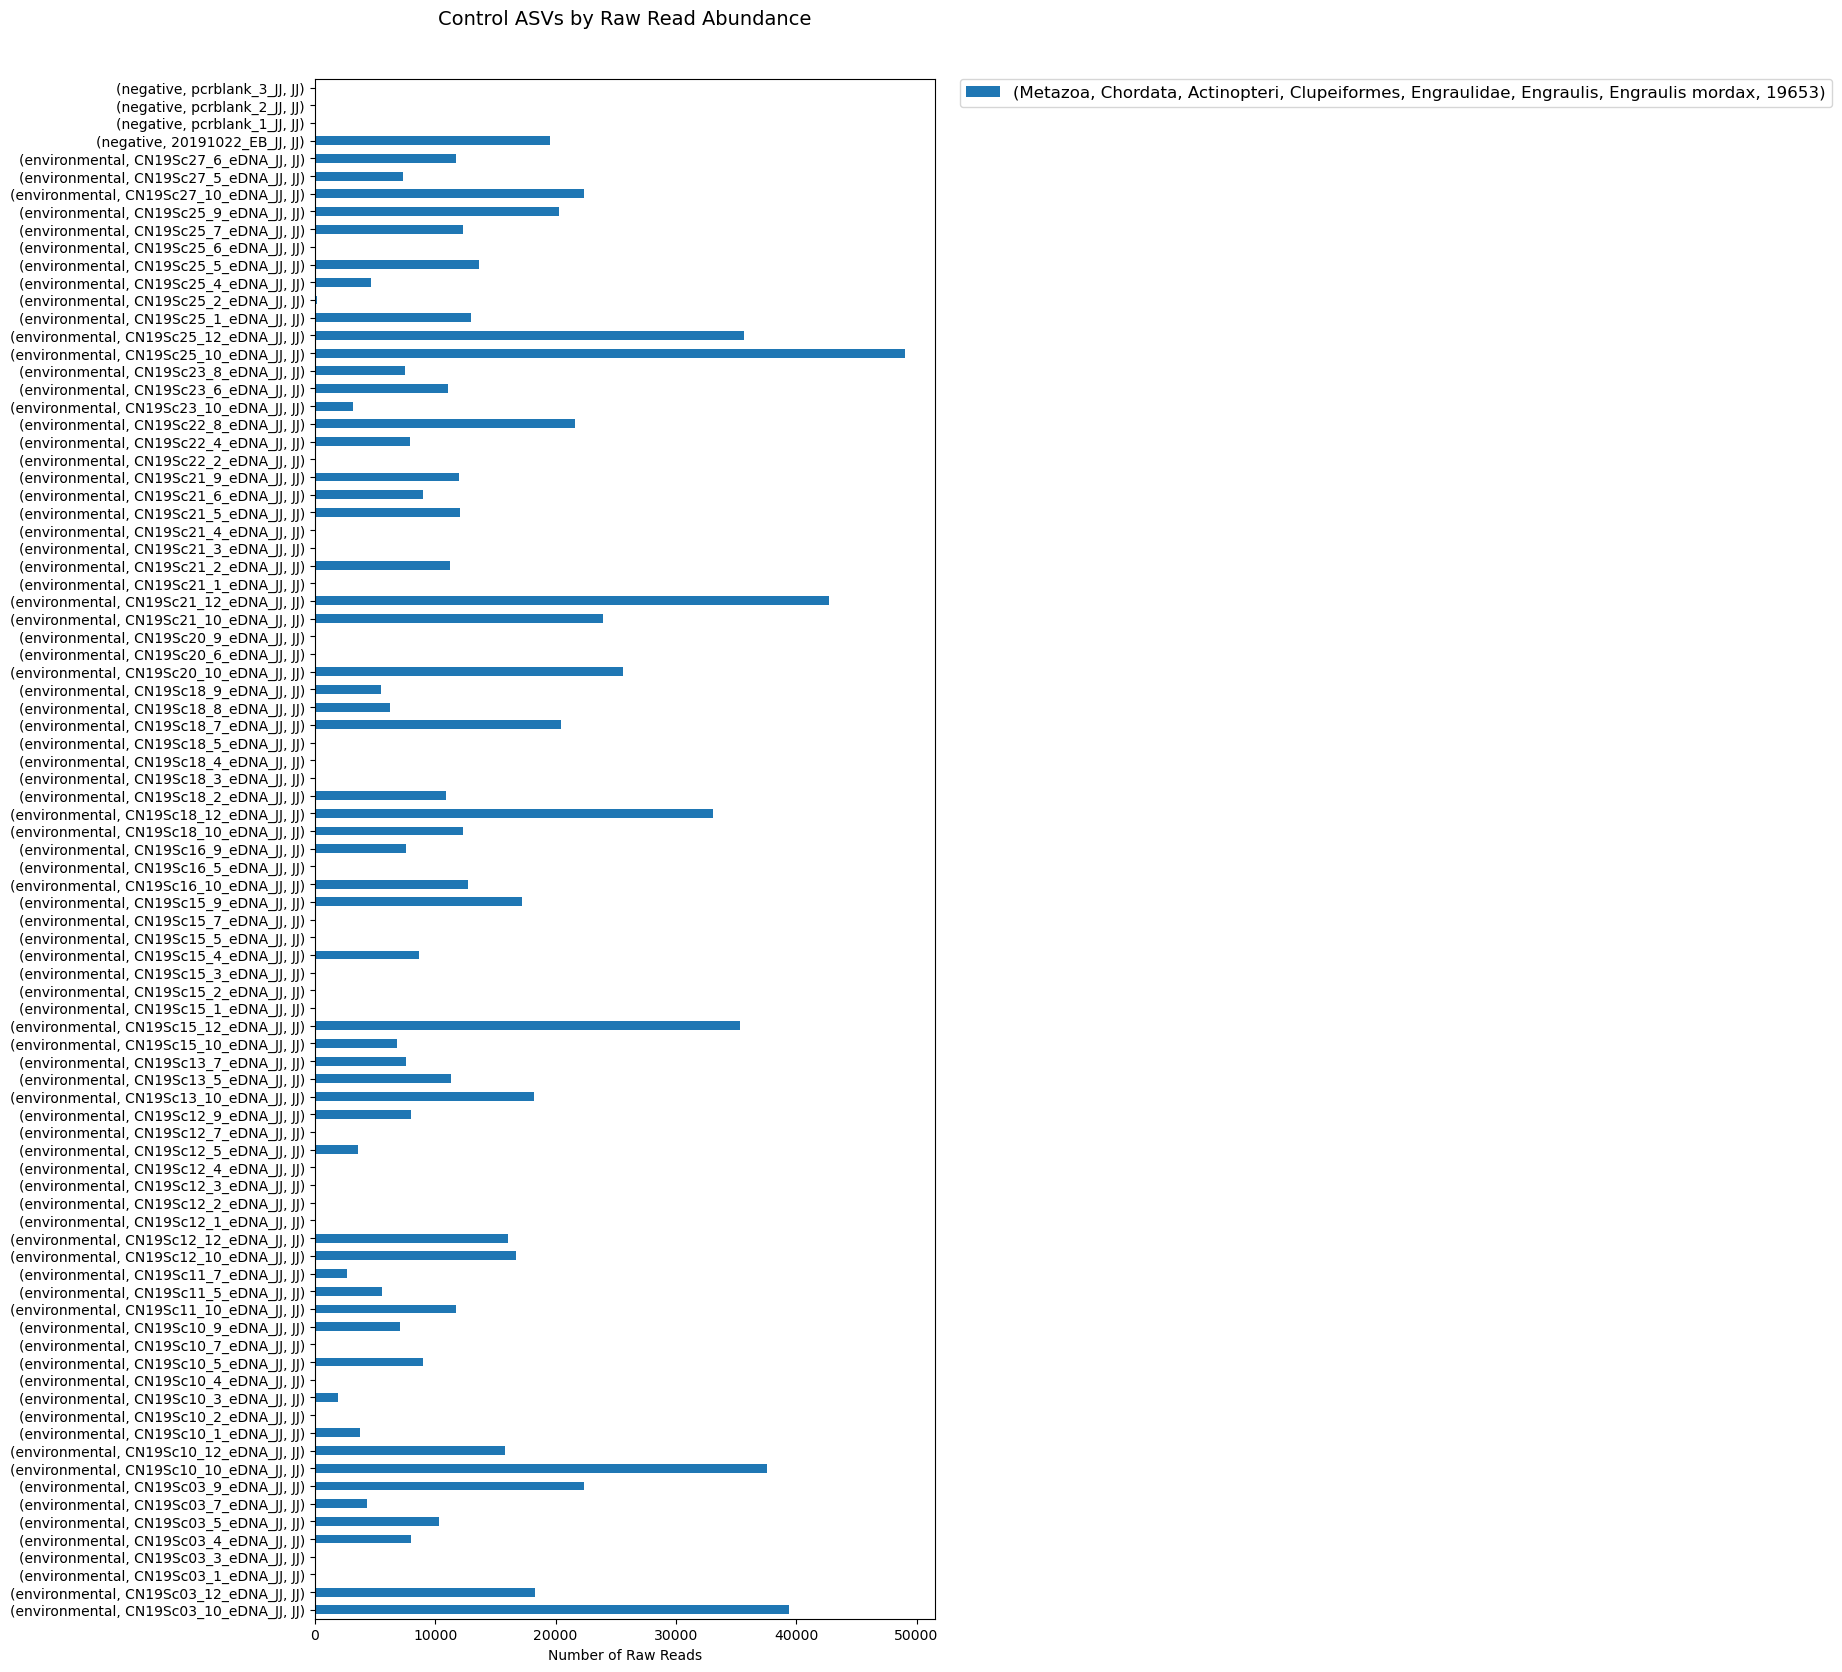

BT
('Tot_neg', '', '')
['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', ('Tot_neg', '', '')]
../figures/controls/ASVs_NegControl_plot_12S_plateBT.pdf


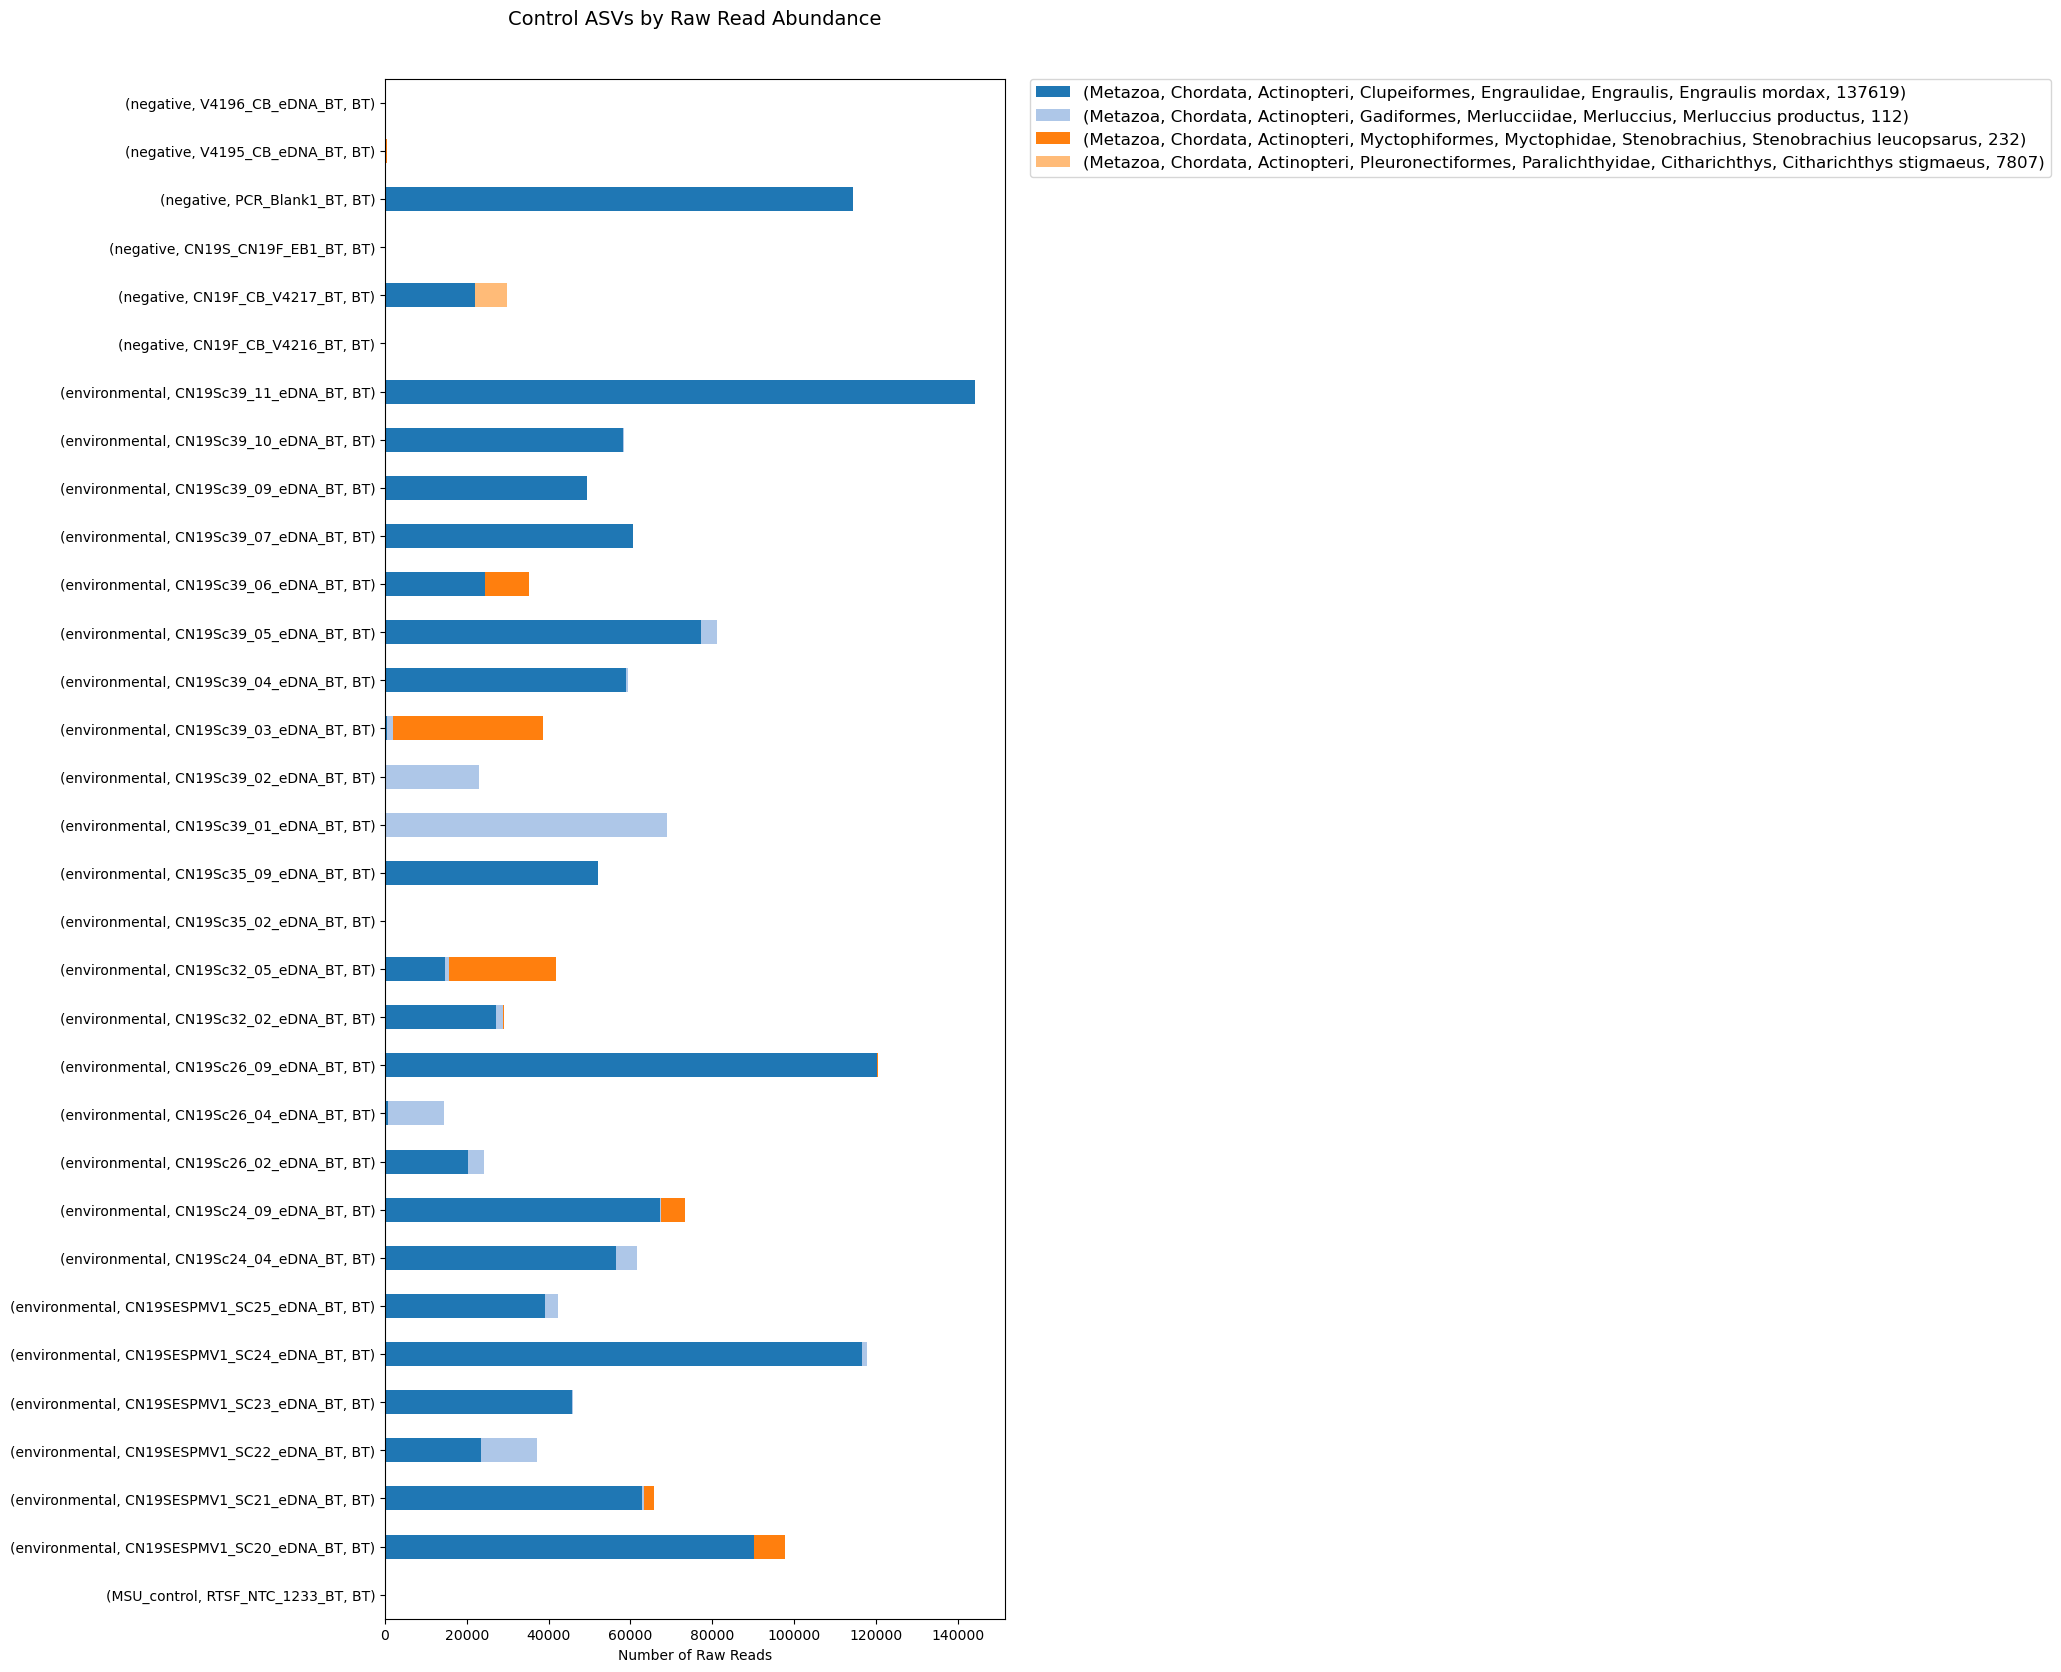

RR
('Tot_neg', '', '')
['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', ('Tot_neg', '', '')]
../figures/controls/ASVs_NegControl_plot_12S_plateRR.pdf


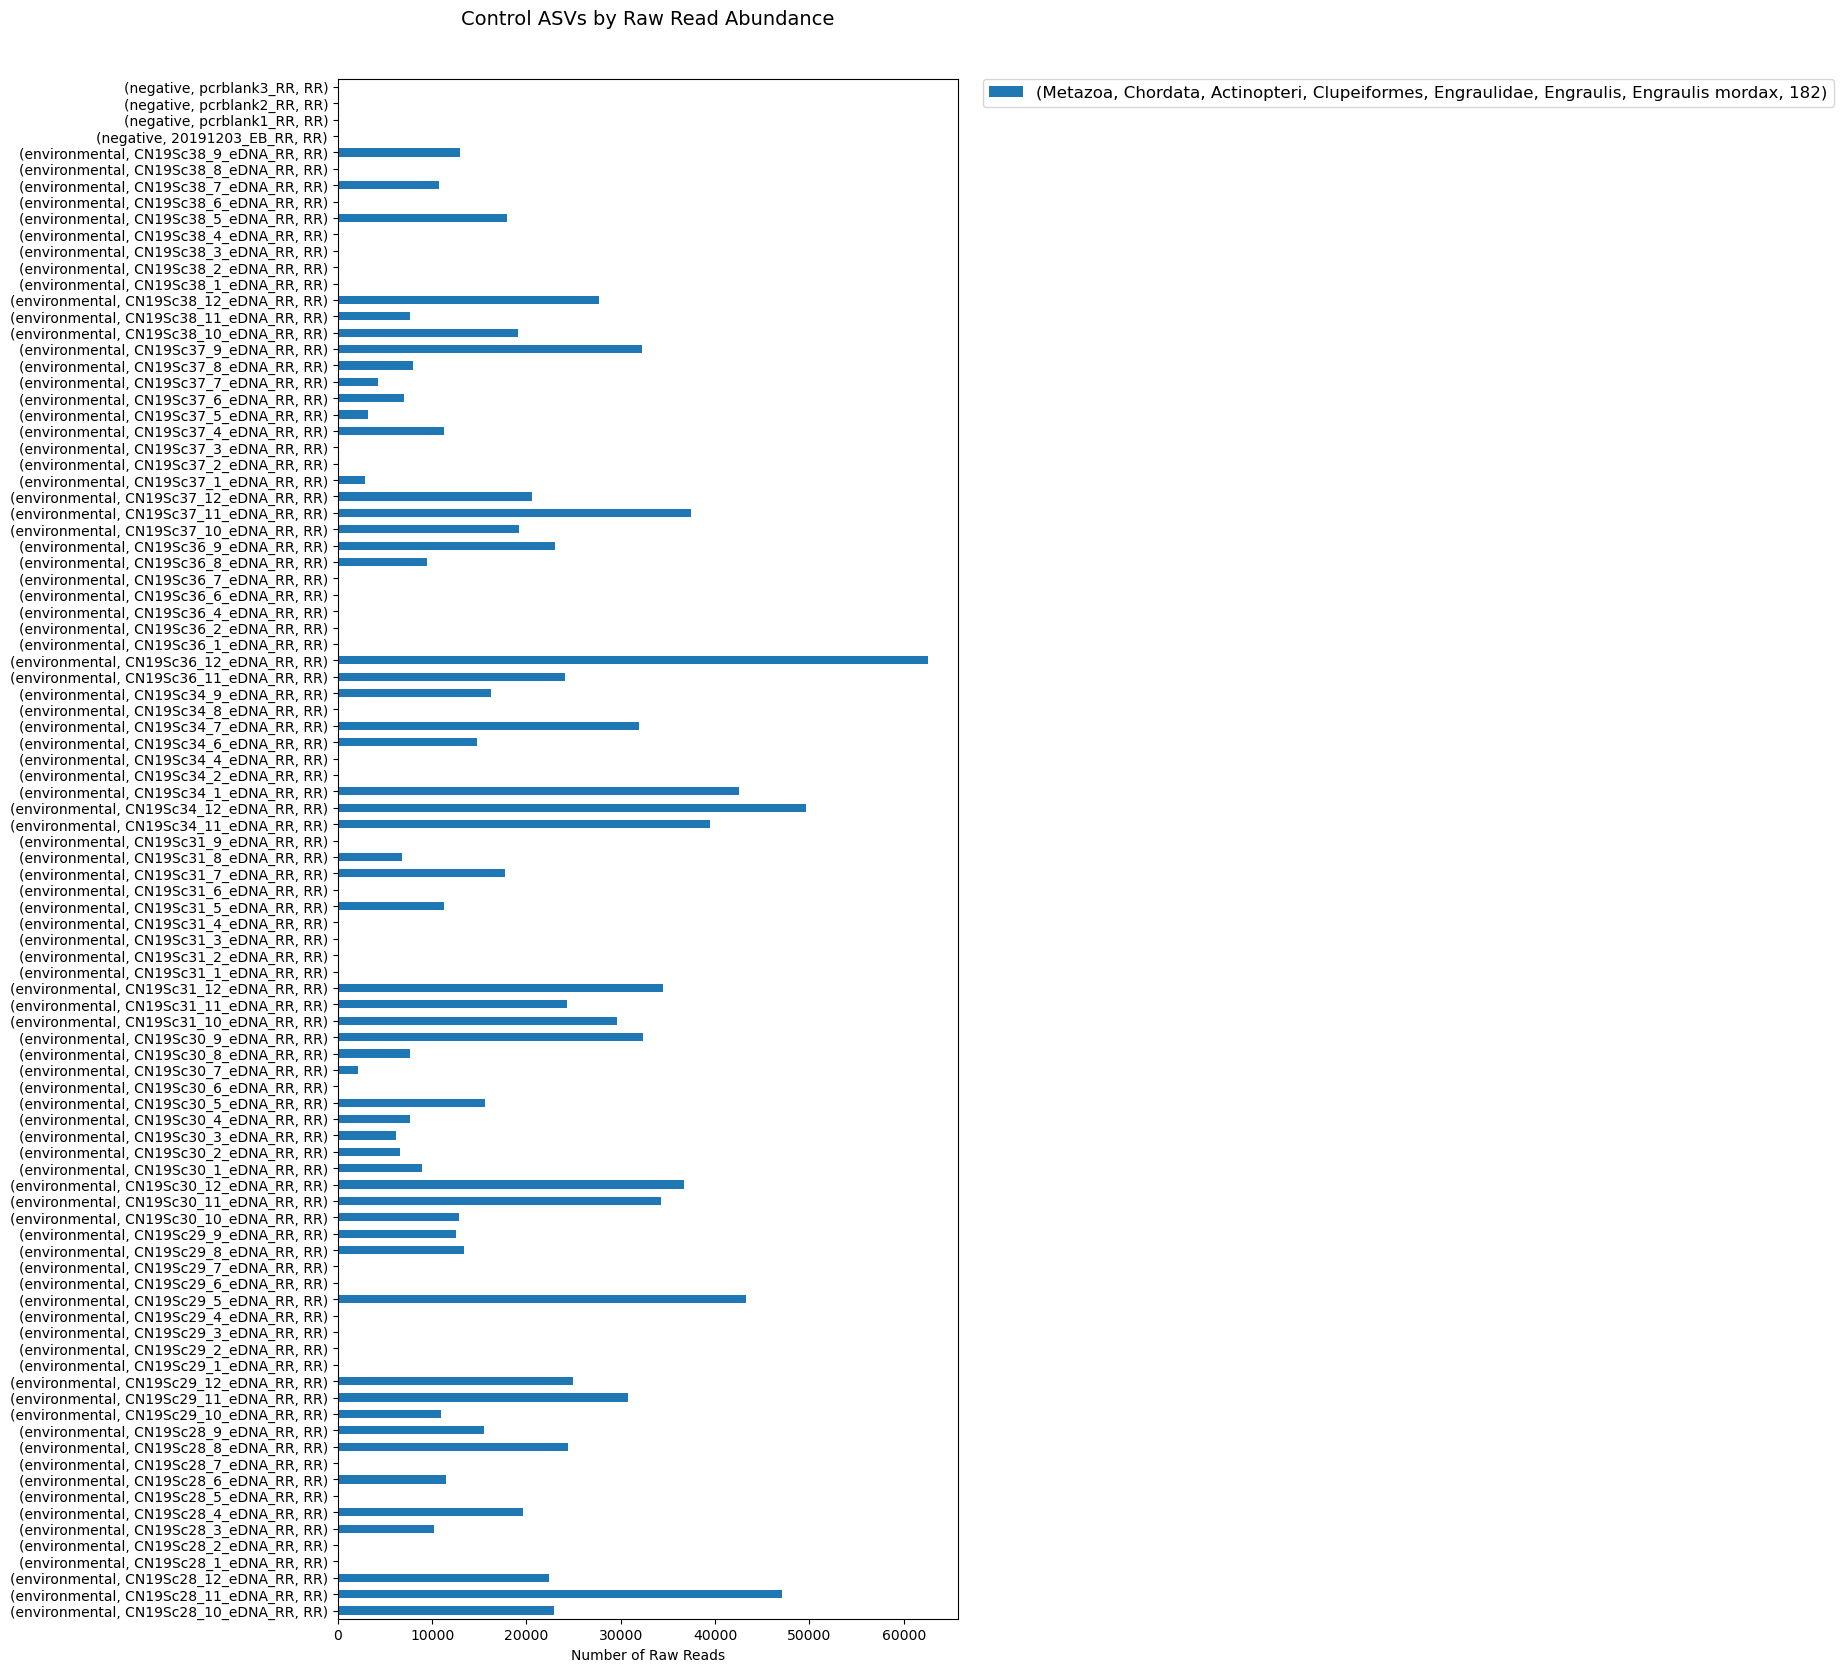

Kingdom                                           Metazoa
Phylum                                           Chordata
Class                                         Actinopteri
Order                                        Clupeiformes
Family                                        Engraulidae
Genus                                           Engraulis
Species                                  Engraulis mordax
('Tot_neg', '', '')                                   182
(environmental, CN19Sc28_10_eDNA_RR, RR)            22915
(environmental, CN19Sc28_11_eDNA_RR, RR)            47110
(environmental, CN19Sc28_12_eDNA_RR, RR)            22402
(environmental, CN19Sc28_1_eDNA_RR, RR)                70
(environmental, CN19Sc28_2_eDNA_RR, RR)                50
...                                                   ...
(environmental, CN19Sc38_9_eDNA_RR, RR)             13005
(negative, 20191203_EB_RR, RR)                         35
(negative, pcrblank1_RR, RR)                           43
(negative, pcrblank2_RR, RR)                           81
(negative, pcrblank3_RR, RR)                           23

[94 rows x 1 columns]

In [55]:
# Calculate on a plate by plate basis:

# taxanomic level to groupby:
grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
levels = list(taxa_all)

# Plates to run over:
libs = meta_all['PlateID'].unique()

for plate in libs:
    #plate = 'NN' # test for ESP sample plate
    print(plate)
    df=meta_all[['PlateID','sample_type']].copy()
    df = df.loc[df['PlateID']==plate]

    # don't count ESP pos controls:
    #df = df.reset_index()
    #df.loc[(df['sample_name'].str.contains('koa3G'))&(df['sample_type']=='positive'), 'sample_type'] = 'ESPpos'
    #df.set_index('sample_name', inplace=True)

    meta_tab_pl = df.copy()
    # get asv table and taxa table by plate:
    asv_tab_pl, taxa_tab_pl = from_metadata_to_taxareads(meta_tab_pl, otu_all, taxa_all)
    # Now limit to ASVs in control samples
    df= pd.concat([meta_tab_pl, asv_tab_pl.T], axis=1,join='inner')
    df.index.name = 'sample_name'
    # don't include positive controls
    df = df.loc[df['sample_type']!='positive']
    df = df.reset_index().set_index(['sample_type', 'sample_name', 'PlateID'])
    df = df.T
    # sum up reads from ASVs in negative controls
    df['Tot_neg'] = df['negative'].sum(axis=1)
    # Only keep ASVs with a minimum number of reads:
    df = df.loc[df['Tot_neg']>=100]
    df = df.sort_values('Tot_neg', ascending=False)

    # remove Tot_pos column?
    col_name = list(df)[-1]
    print(col_name)
    #df.drop(col_name, axis=1, inplace=True)

    # Join with Taxonomy
    df=pd.concat([df, taxa_all], axis=1, join='inner')
    df=df.groupby(levels).sum()
    # don't sum up Tot_pos column
    df['Tot'] = df.drop(col_name, axis=1).sum(axis=1)
    df=df.groupby(grouped).sum()
    df=df.sort_values('Tot', ascending=False)
    df=df.head(n=20)

    #col_name = list(df)[-1]
    #print(col_name)
    #df.drop(col_name, axis=1, inplace=True)
    df.drop('Tot', axis=1, inplace=True)
    cols = levels.copy()
    cols.append(col_name)
    print(cols)
    df = df.reset_index().set_index(cols)
    df = df.sort_index()
    df=df.T
    df = df.sort_index()
    df.plot(kind='barh',stacked=True, color=colors, figsize=[8,20])
    plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
    plt.title('Control ASVs by Raw Read Abundance', y=1.03, fontsize='14')
    plt.xlabel('Number of Raw Reads')
    filename=plot_dir +'ASVs_NegControl_plot_'+marker+'_plate'+plate+'.pdf'
    print(filename)
    plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
            orientation='landscape',  format=None,
            transparent=True, bbox_inches='tight', pad_inches=1)
    plt.show()
    #break
#df = df.sort_values('sample_type')
df

### Look at Terrestrial Contamination

#### By Plate

CE
          Kingdom    Phylum     Class         Order    Family   Genus  \
ASV_7     Metazoa  Chordata  Mammalia  Artiodactyla   Bovidae     Bos   
ASV_19    Metazoa  Chordata  Mammalia  Artiodactyla    Suidae     Sus   
ASV_545   Metazoa  Chordata  Mammalia  Artiodactyla   Bovidae     Bos   
ASV_1775  Metazoa  Chordata  Mammalia  Artiodactyla  Cervidae  Cervus   
ASV_4246  Metazoa  Chordata  Mammalia  Artiodactyla    Suidae     Sus   

                 Species  
ASV_7         Bos taurus  
ASV_19        Sus scrofa  
ASV_545       Bos taurus  
ASV_1775  Cervus elaphus  
ASV_4246      Sus scrofa  
../figures/controls/ASVs_Contam_plot_12S_plateCE.pdf


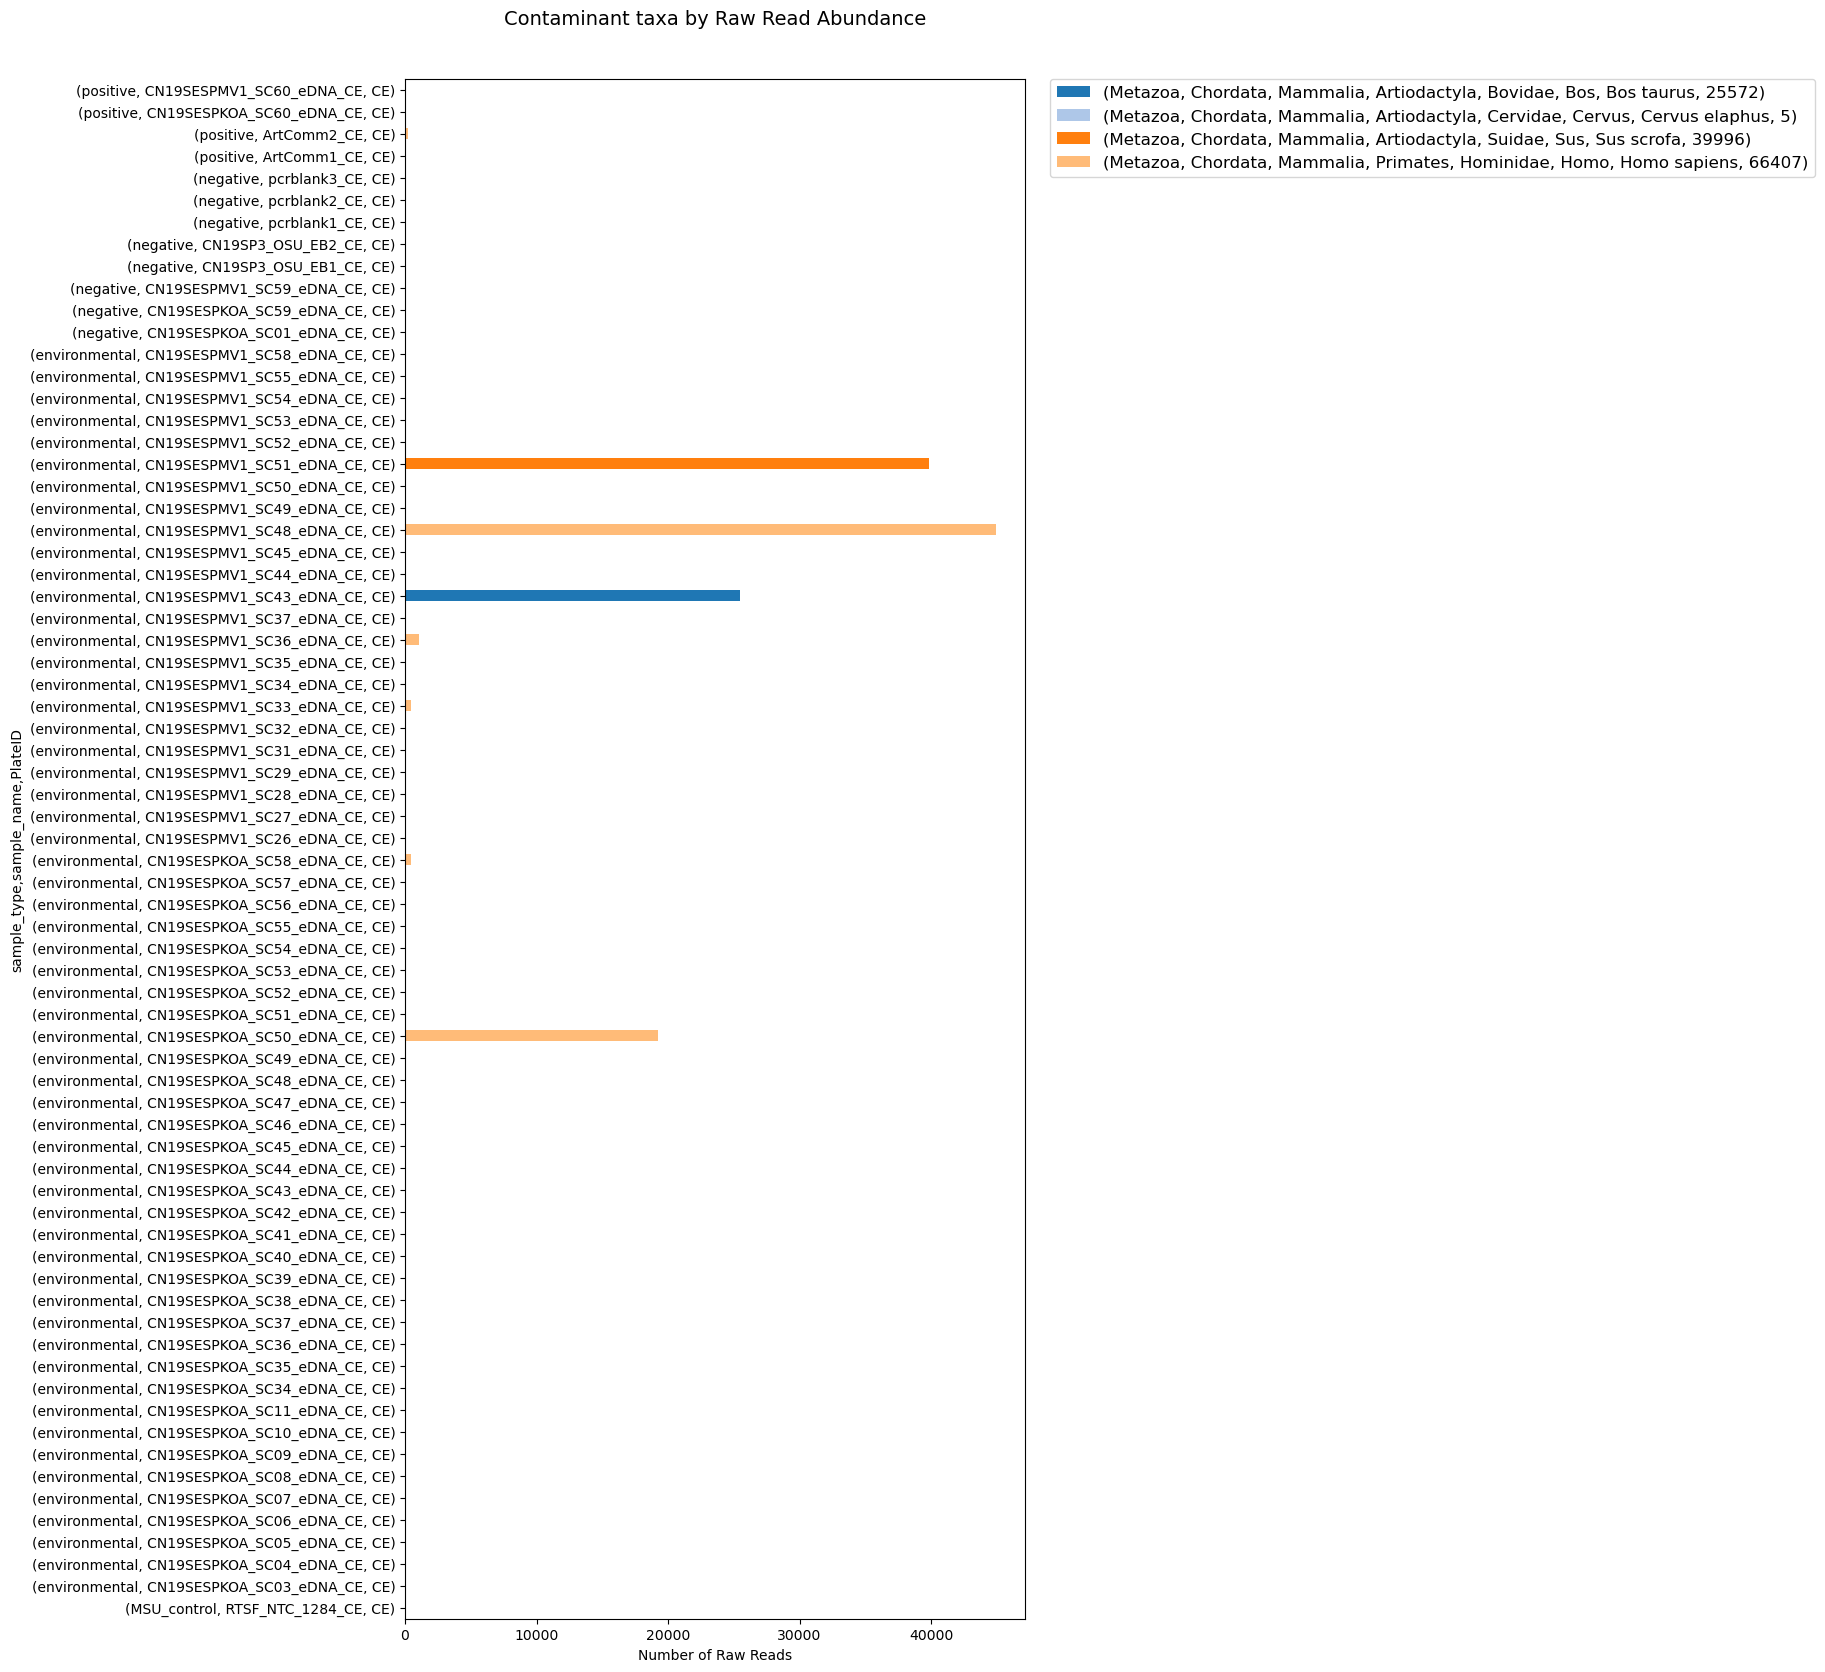

JJ
          Kingdom    Phylum     Class         Order      Family Genus  \
ASV_7     Metazoa  Chordata  Mammalia  Artiodactyla     Bovidae   Bos   
ASV_61    Metazoa  Chordata  Mammalia  Artiodactyla      Suidae   Sus   
ASV_185   Metazoa  Chordata  Mammalia  Artiodactyla     Bovidae   Bos   
ASV_545   Metazoa  Chordata  Mammalia  Artiodactyla     Bovidae   Bos   
ASV_8015  Metazoa  Chordata  Mammalia  Artiodactyla  unassigned    g_   

             Species  
ASV_7     Bos taurus  
ASV_61    Sus scrofa  
ASV_185   Bos taurus  
ASV_545   Bos taurus  
ASV_8015          s_  
../figures/controls/ASVs_Contam_plot_12S_plateJJ.pdf


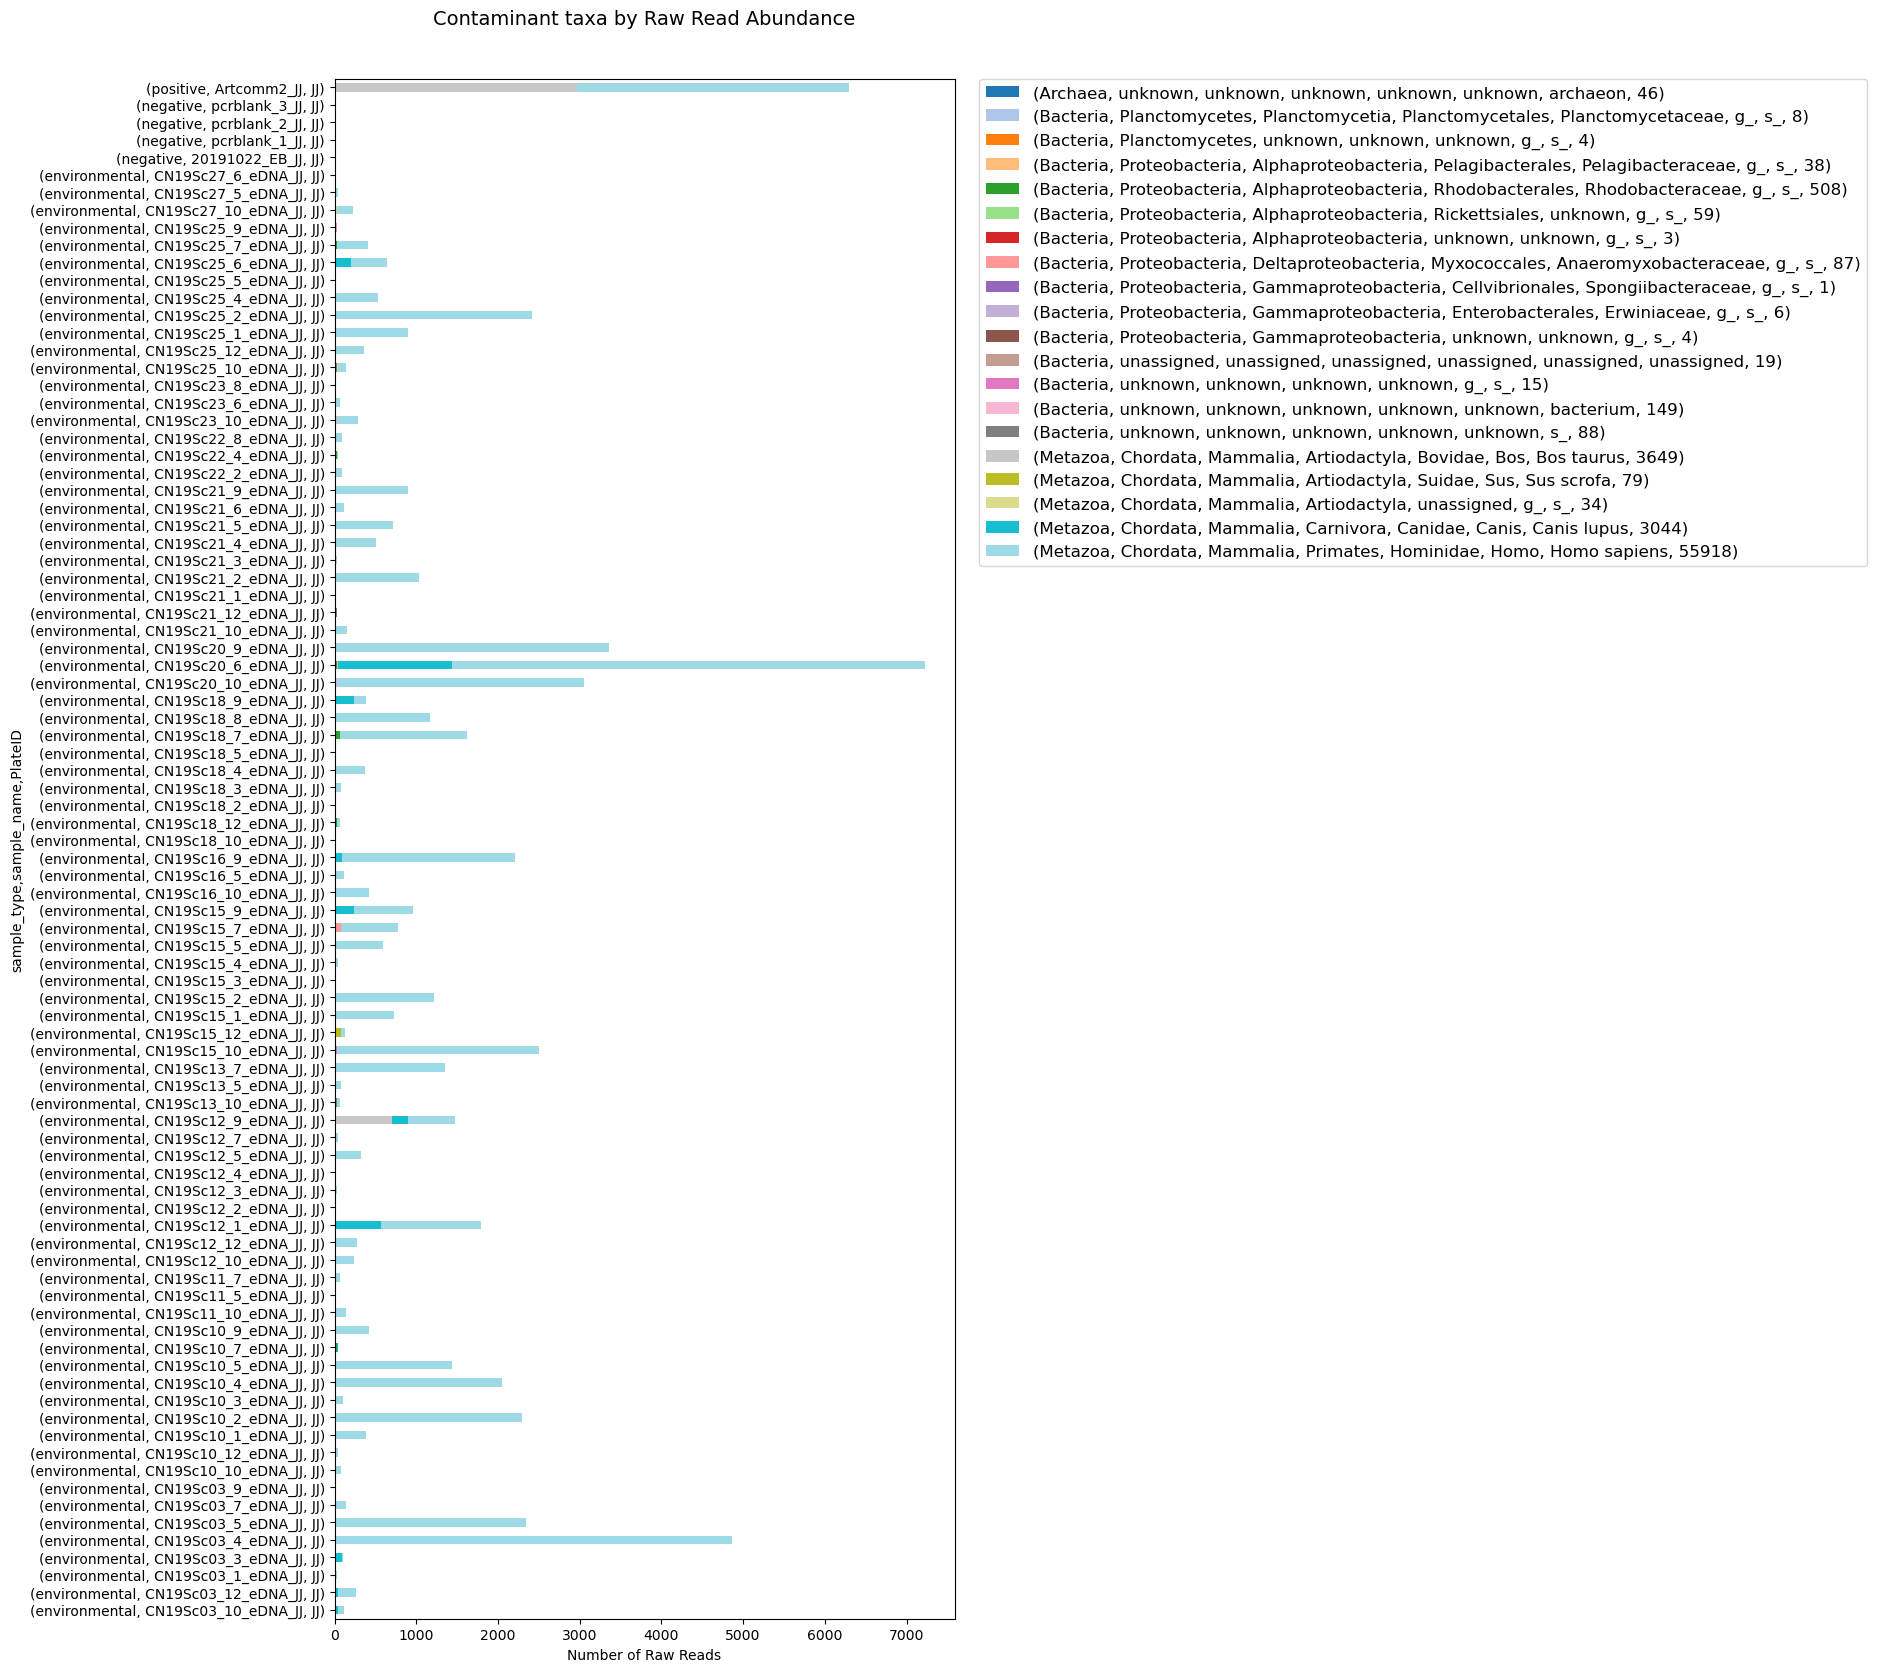

BT
          Kingdom    Phylum     Class         Order   Family Genus     Species
ASV_7     Metazoa  Chordata  Mammalia  Artiodactyla  Bovidae   Bos  Bos taurus
ASV_15    Metazoa  Chordata  Mammalia  Artiodactyla   Suidae   Sus  Sus scrofa
ASV_19    Metazoa  Chordata  Mammalia  Artiodactyla   Suidae   Sus  Sus scrofa
ASV_180   Metazoa  Chordata  Mammalia  Artiodactyla  Bovidae  Ovis  Ovis aries
ASV_273   Metazoa  Chordata  Mammalia  Artiodactyla  Bovidae   Bos  Bos taurus
ASV_2060  Metazoa  Chordata  Mammalia  Artiodactyla  Bovidae   Bos  Bos taurus
../figures/controls/ASVs_Contam_plot_12S_plateBT.pdf


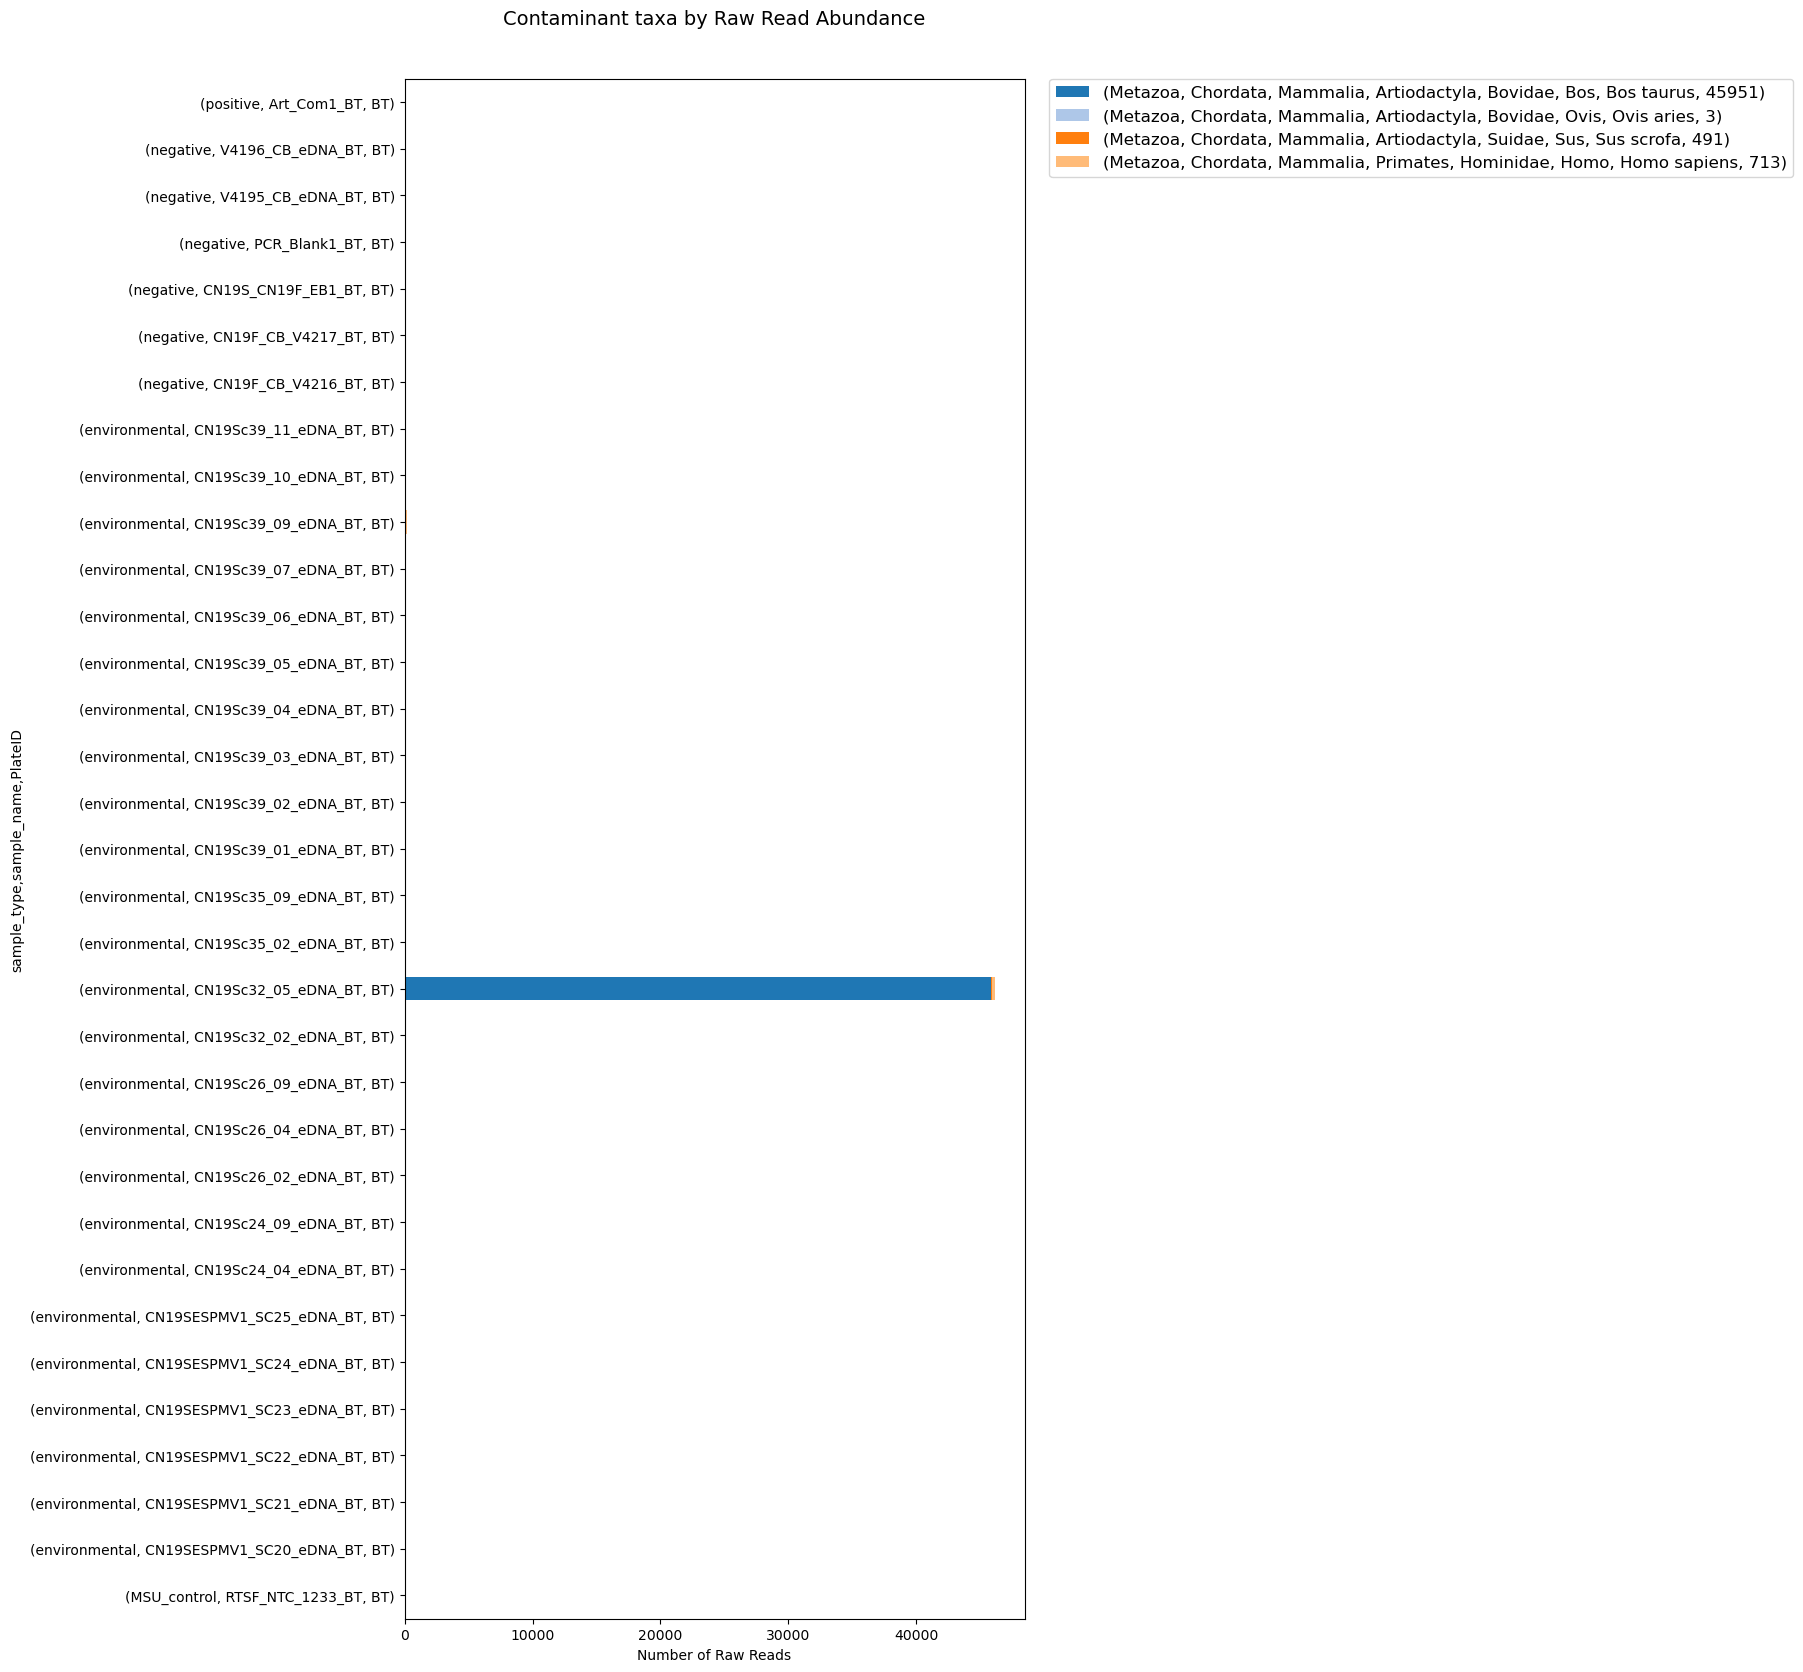

RR
           Kingdom    Phylum     Class         Order        Family     Genus  \
ASV_7      Metazoa  Chordata  Mammalia  Artiodactyla       Bovidae       Bos   
ASV_15     Metazoa  Chordata  Mammalia  Artiodactyla        Suidae       Sus   
ASV_1648   Metazoa  Chordata  Mammalia  Artiodactyla       Bovidae       Bos   
ASV_6771   Metazoa  Chordata  Mammalia  Artiodactyla       Bovidae       Bos   
ASV_8015   Metazoa  Chordata  Mammalia  Artiodactyla    unassigned        g_   
ASV_13898  Metazoa  Chordata  Mammalia  Artiodactyla    unassigned        g_   
ASV_14267  Metazoa  Chordata  Mammalia  Artiodactyla  Physeteridae  Physeter   

                    Species  
ASV_7            Bos taurus  
ASV_15           Sus scrofa  
ASV_1648         Bos taurus  
ASV_6771         Bos taurus  
ASV_8015                 s_  
ASV_13898                s_  
ASV_14267  Physeter catodon  
../figures/controls/ASVs_Contam_plot_12S_plateRR.pdf


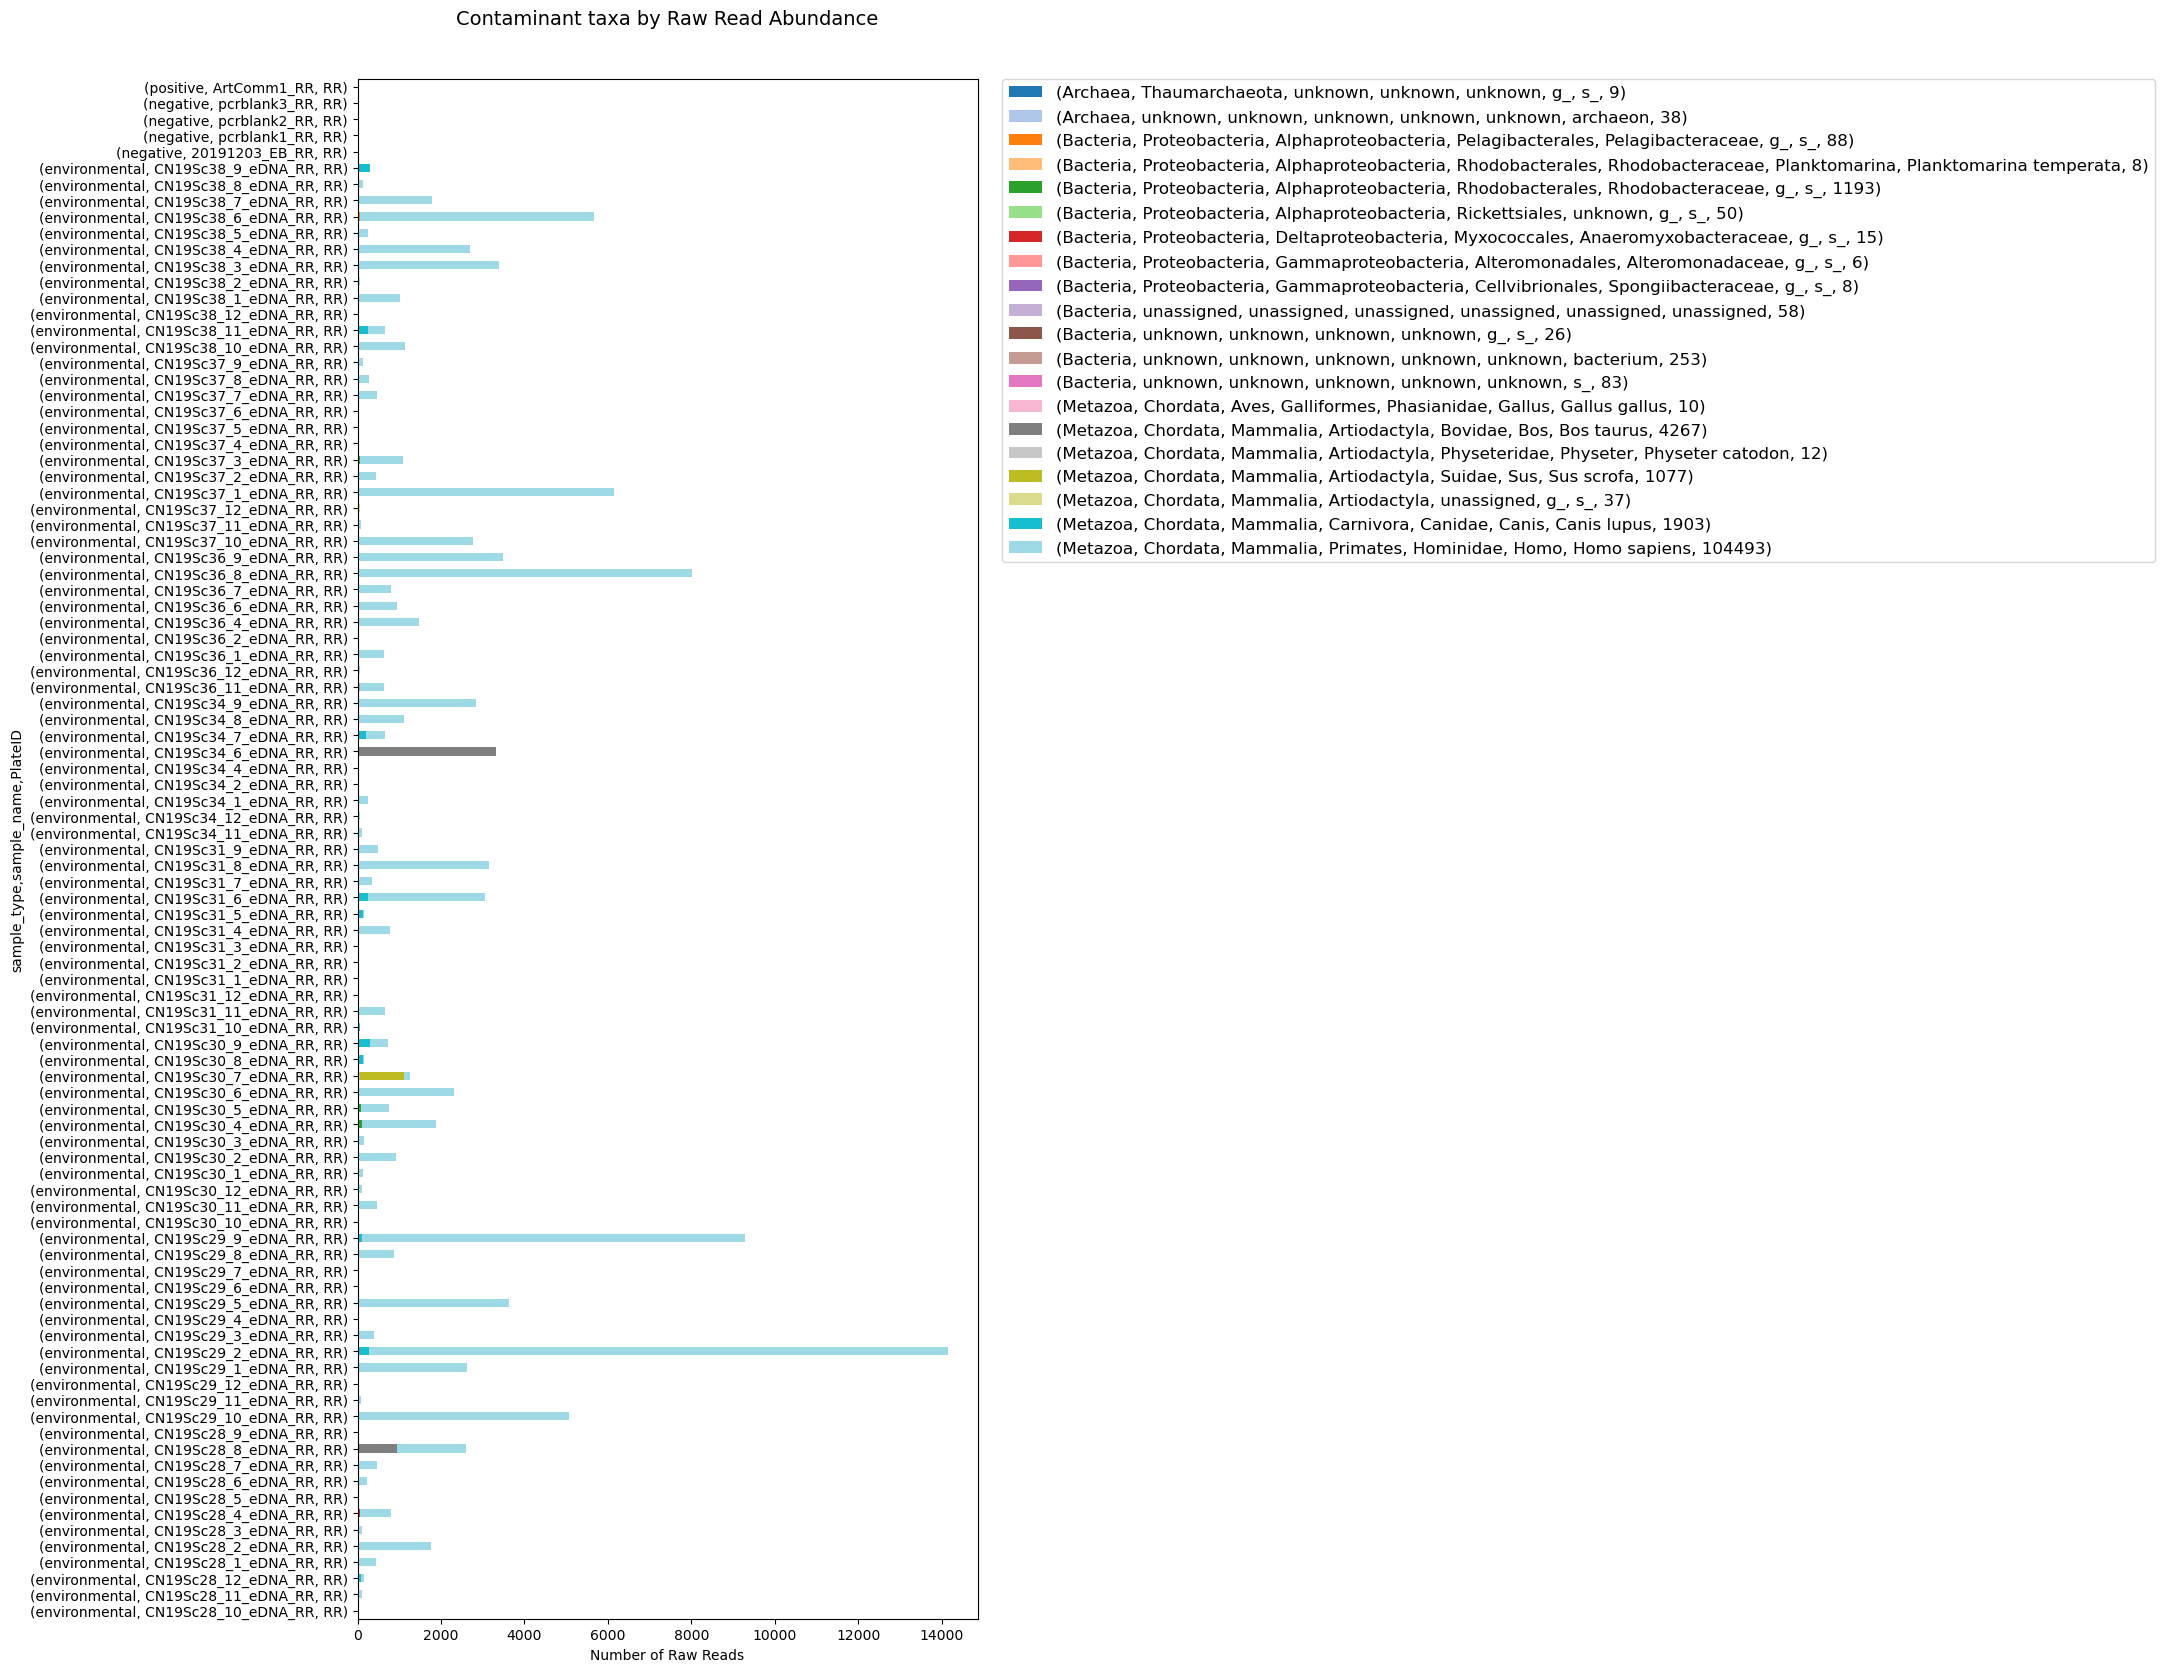

(Archaea, Thaumarchaeota, unknown, unknown, unknown, g_, s_, 9)  \
sample_type   sample_name         PlateID                                                                    
environmental CN19Sc28_10_eDNA_RR RR                                                       0                 
              CN19Sc28_11_eDNA_RR RR                                                       0                 
              CN19Sc28_12_eDNA_RR RR                                                       0                 
              CN19Sc28_1_eDNA_RR  RR                                                       0                 
              CN19Sc28_2_eDNA_RR  RR                                                       0                 
...                                                                                      ...                 
negative      20191203_EB_RR      RR                                                       0                 
              pcrblank1_RR        RR                                                       0                 
              pcrblank2_RR        RR                                                       0                 
              pcrblank3_RR        RR                                                       0                 
positive      ArtComm1_RR         RR                                                       0                 

                                           (Archaea, unknown, unknown, unknown, unknown, unknown, archaeon, 38)  \
sample_type   sample_name         PlateID                                                                         
environmental CN19Sc28_10_eDNA_RR RR                                                       0                      
              CN19Sc28_11_eDNA_RR RR                                                       0                      
              CN19Sc28_12_eDNA_RR RR                                                       0                      
              CN19Sc28_1_eDNA_RR  RR                                                       0                      
              CN19Sc28_2_eDNA_RR  RR                                                       0                      
...                                                                                      ...                      
negative      20191203_EB_RR      RR                                                       0                      
              pcrblank1_RR        RR                                                       0                      
              pcrblank2_RR        RR                                                       0                      
              pcrblank3_RR        RR                                                       0                      
positive      ArtComm1_RR         RR                                                       0                      

                                           (Bacteria, Proteobacteria, Alphaproteobacteria, Pelagibacterales, Pelagibacteraceae, g_, s_, 88)  \
sample_type   sample_name         PlateID                                                                                                     
environmental CN19Sc28_10_eDNA_RR RR                                                       0                                                  
              CN19Sc28_11_eDNA_RR RR                                                       0                                                  
              CN19Sc28_12_eDNA_RR RR                                                       0                                                  
              CN19Sc28_1_eDNA_RR  RR                                                       1                                                  
              CN19Sc28_2_eDNA_RR  RR                                                       0                                                  
...                                                                                      ...                       

In [57]:
# Calculate on a plate by plate basis:

# taxanomic level to groupby:
grouped = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
levels = list(taxa_all)

# Plates to run over:
libs = meta_all['PlateID'].unique()
for plate in libs:
    # plate = 'NN' # test for ESP sample plate
    print(plate)
    df=meta_all[['PlateID','sample_type']].copy()
    df = df.loc[df['PlateID']==plate]

    # don't count ESP pos controls:
    df = df.reset_index()
    df.loc[(df['sample_name'].str.contains('koa3G'))&(df['sample_type']=='positive'), 'sample_type'] = 'ESPpos'
    df.set_index('sample_name', inplace=True)
    
    # merge types of negatives:
    # 'negative','MSU_control', 'blank'
    df['sample_type'] = df['sample_type'].str.replace('MSU_control|blank','negative')
    
    meta_tab_pl = df.copy()
    # get asv table and taxa table by plate:
    asv_tab_pl, taxa_tab_pl = from_metadata_to_taxareads(meta_tab_pl, otu_all, taxa_all)
    
    # Limit taxa table to "contaminants":
    df = taxa_tab_pl.copy()
    # check any mismatches:
    print(df.loc[df['Order']=='Artiodactyla'])
    df.loc[df['Family'].isin(['Eschrichtiidae']), 'Order'] = 'Cetacea'
    # Start defining contams:
    df['contam'] = ''
    df.loc[df['Kingdom'].isin(['Bacteria', 'Archaea']), 'contam'] = 1
    df.loc[df['Class'].isin(['Insecta', 'Arachnida','Amphibia']), 'contam'] = 1
    df.loc[df['Order'].isin(['Artiodactyla']), 'contam'] = 1
    fams = ['Hominidae','Canidae','Scincidae','Suidae', 'Bovidae', 'Felidae',
        'Phasianidae','Castoridae','Hirundinidae','Sittidae','Columbidae',
        'Falconidae','Leporidae','Muridae','Fringillidae','Mephitidae',
        'Rhinolophidae','Certhiidae']
    df.loc[df['Family'].isin(fams), 'contam'] = 1
    # Freshwater fish??
    # Order "Cyprinodontiformes", "Siluriformes", "Characiformes"
    fw_orders = ["Cyprinodontiformes", "Siluriformes", "Characiformes","Cypriniformes" ]
    df.loc[df['Order'].isin(fw_orders), 'contam'] = 1
    
    df = df.loc[df['contam']==1]
    df = df.drop('contam', axis=1)
    # Now limit to ASVs in terrestrial contam list
    df= pd.concat([df, asv_tab_pl], axis=1,join='inner')
    df=df.groupby(levels).sum()

    df['Tot'] = df.sum(axis=1)
    df=df.groupby(grouped).sum()
    df=df.sort_values('Tot', ascending=False)
    df=df.head(n=20)
    #df.drop('Tot', axis=1, inplace=True)
    # add it into index:
    df = df.reset_index()
    cols = levels.copy()
    cols.append('Tot')
    df.set_index(cols, inplace=True)

    df = df.T
    df = pd.concat([df, meta_tab_pl], axis=1)
    df.index.name = 'sample_name'
    df = df.reset_index().set_index(['sample_type', 'sample_name', 'PlateID'])
    
    df = df.sort_index()
    df=df.T
    df = df.sort_index()
    df=df.T
    df.plot(kind='barh',stacked=True, color=colors, figsize=[8,20])
    plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')
    plt.title('Contaminant taxa by Raw Read Abundance', y=1.03, fontsize='14')
    plt.xlabel('Number of Raw Reads')
    filename=plot_dir +'ASVs_Contam_plot_'+marker+'_plate'+plate+'.pdf'
    print(filename)
    plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
            orientation='landscape',  format=None,
            transparent=True, bbox_inches='tight', pad_inches=1)
    plt.show()
    # break
#df = df.sort_values('sample_type')
df